In [1]:
from __future__ import division
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

import warnings
import sys
import os
import itertools
import datetime

import numpy as np
import pandas as pd
from pandas import TimeGrouper
import random

import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
pyoff.init_notebook_mode()

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
SAVE_PROCESSED_DATA = True

In [3]:
scriptDir = os.getcwd()
relPath = r"../Customer Segmentation/"
sampleFilePath = os.path.join(scriptDir, relPath, 'CJ filtered.csv')
relPathOutput = r"../output/"
outputFolderPath = os.path.join(scriptDir, relPathOutput)

# Importing Packages and Loading Data

In [4]:
# Load AirPartner Data
df = pd.read_csv(sampleFilePath, sep=',', header=0, quotechar='"', encoding='latin1')
print('Dataframe dimensions:', df.shape)

Dataframe dimensions: (8809, 7)


In [5]:
# df.groupby(['Flight Year','brokercountry'])['gross'].sum()

In [6]:
# save = pd.DataFrame(df, columns = ['qtq_firstflightdate', 'gross', 'Product', 'brokercountry', 'Accountid', 'owner', 'creation date']) 
df = df.rename(columns={'qtq_firstflightdate':'Flight date'})
df['Flight date'] = pd.to_datetime(df['Flight date'])
train = df[df['Flight date'] < datetime.datetime(2019,8,22)]
test =  df[df['Flight date'] >= datetime.datetime(2019,8,22)]

In [7]:
train.set_index(['Flight date'], inplace=True)
train.to_csv('Train.csv')

test.set_index(['Flight date'], inplace=True)
test.to_csv('Test.csv')

In [8]:
tsFile = '../TimeSeries/train.csv.'
ts = pd.read_csv(tsFile, index_col=None, parse_dates=[0])
ts = ts.sort_index(ascending=True)

## Resample the monthly gross
- The 'MS' string groups the data in buckets by start of the month

In [ ]:
import plotly.io as pio
from plotly.subplots import make_subplots

In [ ]:
# Creat a YearMonth col for the report and visualization
ts['FlightYearMonth'] = ts['Flight date'].map(lambda x: 100*x.year + x.month)

In [ ]:
ts_GP = ts.groupby(['FlightYearMonth'])['Grossprofit'].sum().reset_index()
ts_GP['MonthlyGrowth'] = (ts_GP['Grossprofit'] - ts_GP['Grossprofit'].shift(1)) / ts_GP['Grossprofit'].shift(1)

In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Bar(x = ts_GP['FlightYearMonth'], y = ts_GP['Grossprofit'], name="Gross Profit"), secondary_y=False)

fig.add_trace(
    go.Scatter(x = ts_GP.query('FlightYearMonth < 201907')['FlightYearMonth'], 
    y = ts_GP.query('FlightYearMonth < 201907')['MonthlyGrowth'], name='Growth Rate'), secondary_y=True)

plot_layout = go.Layout(
            xaxis = {'type':'category'},
            title = 'Monthly Gross Profit and Growth Rate From 2014 to 2019',
            paper_bgcolor='rgba(0,0,0,0)',
            plot_bgcolor='rgba(0,0,0,0)'
        )
fig.update_layout(plot_layout)

fig.update_yaxes(title_text="<b>Monthly Gross Profit</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Monthly Growth Rate</b>", secondary_y=True)

fig.show()

This clearly shows the revenue is decreasing onwards (our data in July is incomplete). Absolute numbers are fine, let's figure out what is our Monthly Revenue Growth Rate.

We saw a 6.2% growth previous month (July is excluded in the code since it hasn't been completed yet). But we need to identifyy what exactly happened on May. Was it due to less active customer or our customer did less orders? Maybe they just started to buy cheaper products?

In [ ]:
df.columns

### Monthly Order Number and Growth Rate
- We will be focusng on UK data only (which has the most records). We can get the monthly active customers by counting unique CustomerIDS.

In [ ]:
ts_uk = ts.query("brokercountry=='United Kingdom'").reset_index(drop=True)

# Creating monthly active customers dataframe by counting unique Accountid
ts_monthly_active = ts_uk.groupby('FlightYearMonth')['Accountid'].nunique().reset_index()
ts_monthly_active['MonthlyActiveRate'] = (ts_monthly_active['Accountid'] - ts_monthly_active['Accountid'].shift(1)) / \
                                        ts_monthly_active['Accountid'].shift(1)

In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Bar(x = ts_monthly_active.query('FlightYearMonth < 201811')['FlightYearMonth'], y = ts_monthly_active.query('FlightYearMonth < 201811')['Accountid'], name="Total Order Number", marker_color='MediumPurple'), secondary_y=False)

fig.add_trace(
    go.Scatter(x = ts_monthly_active.query('FlightYearMonth < 201811')['FlightYearMonth'], 
    y = ts_monthly_active.query('FlightYearMonth < 201811')['MonthlyActiveRate'], name='Growth Rate', marker_color='Orange'), secondary_y=True)

plot_layout = go.Layout(
            xaxis = {'type':'category'},
            title = 'Monthly Order Number and Growth Rate From 2014 to 2018.11',
            plot_bgcolor='white',
        )
fig.update_layout(plot_layout)

fig.update_yaxes(title_text="<b>Monthly Order Number</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Monthly Growth Rate</b>", secondary_y=True)

fig.show()

In [ ]:
ts_monthly_active['Accountid'].mean()

In [ ]:
# Creating monthly active customers dataframe by counting unique Accountid
ts_monthly_active = ts_uk.groupby('FlightYearMonth')['Accountid'].nunique().reset_index()
ts_monthly_active['MonthlyActiveRate'] = (ts_monthly_active['Accountid'] - ts_monthly_active['Accountid'].shift(1)) / \
                                        ts_monthly_active['Accountid'].shift(1)

plot_data = [
    go.Bar(
        x=ts_monthly_active['FlightYearMonth'],
        y=ts_monthly_active.query('MonthlyActiveRate > 0')['MonthlyActiveRate'],
        name = 'Postive Order Growth Rate',
        marker_color='green'),
    go.Bar(
        x=ts_monthly_active['FlightYearMonth'],
        y=ts_monthly_active.query('MonthlyActiveRate < 0')['MonthlyActiveRate'],
        name = 'Negative Order Growth Rate',
        marker_color='firebrick')
]

plot_layout = go.Layout(
        xaxis={"type":"category"},
        title='Monthly Order Growth Rate',
        plot_bgcolor='white',)

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In the October, Monthly Active Customer number dropped to 5 from 16 (-68.8%).
We will the same trend for number of orders as well.

### Monthly Active Owner

In [ ]:
owner_monthly_active = ts_uk.groupby('FlightYearMonth')['owner'].nunique().reset_index()
owner_monthly_active['MonthlyActiveRate'] = (owner_monthly_active['owner'] - owner_monthly_active['owner'].shift(1)) / \
                                        owner_monthly_active['owner'].shift(1)

In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Bar(x = owner_monthly_active['FlightYearMonth'], y = owner_monthly_active['owner'], name="No.Active Owner", marker_color='royalblue'), secondary_y=False)

fig.add_trace(
    go.Scatter(x = owner_monthly_active['FlightYearMonth'], y = owner_monthly_active['MonthlyActiveRate'], name='Active Rate', line = dict(color='firebrick', width=2)), secondary_y=True)

plot_layout = go.Layout(
            xaxis = {'type':'category'},
            title = 'Monthly Gross Profit and Gross Rate From 2014 to 2019',
            plot_bgcolor='white',
        )
fig.update_layout(plot_layout)

fig.update_yaxes(title_text="<b>Monthly Gross Profit</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Monthly Growth Rate</b>", secondary_y=True)

fig.show()

In the October, Monthly Active Owner number dropped to 4m from 9 (-55.6%).

## Average Revenue per Owner
- to get tmhis data, we need to calculate the average of revenue for each month

In [ ]:
ts_monthly_order_sales = ts_uk.groupby(['FlightYearMonth', 'product'])['Grossprofit'].mean().reset_index()

plot_layout = go.Layout(
            xaxis={"type":"category"},
            title='CJ vs TourOps on Monthly Order Average',)

fig = go.Figure(layout=plot_layout)
fig.add_trace(go.Bar(
        x=ts_monthly_order_sales.query("product == 'CJ'")['FlightYearMonth'],
        y=ts_monthly_order_sales.query("product == 'CJ'")['Grossprofit'],
        marker_color='rgb(55, 83, 109)',
        name = 'CJ - Adhoc'))

fig.add_trace(go.Bar(
        x=ts_monthly_order_sales.query("product == 'Tour Ops'")['FlightYearMonth'],
        y=ts_monthly_order_sales.query("product == 'Tour Ops'")['Grossprofit'],
        marker_color='royalblue',
        name = 'Tour Ops'))

# fig.update_layout(barmode='relative')
pyoff.iplot(fig)

In [ ]:
ts_monthly_order_sales['Grossprofit'].describe()

Even the monthly order average dropped for May (9352 to 1523). We observed slow-down in every metric affecting our North Star.

## New Customer Ratio
- a good idicator of if we are losing our existing customers or unable to attract new ones

In [ ]:
# ts_min_purchase = ts_uk.groupby('Accountid')['Flight date'].min().reset_index()
# ts_min_purchase.columns = ['Accountid', 'MinPuchaseDate']
# ts_min_purchase['MinPuchaseYearMonth'] = ts_min_purchase['MinPuchaseDate'].map(lambda x:100*x.year + x.month)

# ts_uk = pd.merge(ts_uk, ts_min_purchase, on='Accountid')

# # # Create a column called User Type and assign Existing
# # ## If User's First Purcahse Year Month before the selected Purchase Year Month
# ts_uk['UserType'] = 'New'
# ts_uk.loc[ts_uk['FlightYearMonth'] > ts_uk['MinPuchaseYearMonth'], 'UserType'] = 'Existing'

# # # Calculate the Revenue per Month for each user type
# ts_user_type_revenue = ts_uk.groupby(['FlightYearMonth', 'UserType'])['Grossprofit'].sum().reset_index()
# # #Filtering the dates and plot the result
# ts_user_type_revenue = ts_user_type_revenue.query('FlightYearMonth != 201908' and 'FlightYearMonth != 201602')

In [ ]:
# plot_data = [
#     go.Scatter(
#         x = ts_user_type_revenue.query("UserType == 'Existing'")['FlightYearMonth'],
#         y = ts_user_type_revenue.query("UserType == 'Existing'")['gross'],
#         name = 'Existing',
#         marker_color = 'royalblue'),
#     go.Scatter(
#         x = ts_user_type_revenue.query("UserType == 'New'")['FlightYearMonth'],
#         y = ts_user_type_revenue.query("UserType == 'New'")['gross'],
#         mode = 'lines+markers',
#         name = 'New',
#         marker_color='firebrick')
# ]

# plot_layout = go.Layout(
#     xaxis={"type":"category"},
#     title='New vs Existing on Monthly Gross Profit')

# fig = go.Figure(data=plot_data, layout=plot_layout)
# pyoff.iplot(fig)

In [ ]:
# ts_user_type_revenue.query('FlightYearMonth != 201908' and 'FlightYearMonth != 201602').head()

In [ ]:
# ts_user_ratio = ts_uk.query("UserType == 'New'").groupby(['FlightYearMonth'])['Accountid'].nunique() / \
#                 ts_uk.query("UserType == 'Existing'").groupby(['FlightYearMonth'])['Accountid'].nunique()
# ts_user_ratio = ts_user_ratio.reset_index()
# ts_user_ratio = ts_user_ratio.dropna()

In [ ]:
# plot_data = [
#     go.Scatter(
#         x=ts_user_ratio.query("FlightYearMonth>201401 and FlightYearMonth<201907")['FlightYearMonth'],
#         y=ts_user_ratio.query("FlightYearMonth>201401 and FlightYearMonth<201907")['Accountid'],
#         marker_color = 'royalblue')
# ]

# plot_layout = go.Layout(
#         xaxis={'type':'category'},
#         title='New Customer Ratio in UK Office')

# fig = go.Figure(data=plot_data, layout=plot_layout)
# pyoff.iplot(fig)

In [ ]:
# ts_uk.groupby(['owner','FlightYearMonth'])[ 'Accountid'].count()

New Customer Ratio has declined as expected, takes example of 2018, normaly the spring is the lowest and summer season reach the peak.

## Monthly Retention Rate
Retention rate indicates how sticky is your service and how well your product fits the market. For making Monthly Retention Rate visualized, we need to calculate how many customers retained from previous month.

**Monthly Retention Rate** == Retained Customers From Prev.Month / Active Customers Total

In [ ]:
# ts_user_purchase = ts_uk.groupby(['Accountid', 'FlightYearMonth'])['gross'].sum().reset_index()

# ts_retention = pd.crosstab(ts_user_purchase['Accountid'], ts_user_purchase['FlightYearMonth'])
# ts_retention.head()

In [ ]:
# months = ts_retention.columns[2:]
# retention_array = []
# for i in range(len(months)-1):
#     retention_data = {}
#     selected_month = months[i+1]
#     prev_month = months[i]
#     retention_data['FlightYearMonth'] = int(selected_month)
#     retention_data['TotalUserCount'] = ts_retention[selected_month].sum()
#     retention_data['RetainedUserCount'] = ts_retention[(ts_retention[selected_month]>0) & (ts_retention[prev_month]>0)][selected_month].sum()
#     retention_array.append(retention_data)

In [ ]:
# ts_retention = pd.DataFrame(retention_array)
# ts_retention['RetentionRate'] = round(ts_retention['RetainedUserCount'] / ts_retention['TotalUserCount'], 2)

In [ ]:
# plot_data = [
#     go.Scatter(
#         x = ts_retention.query("FlightYearMonth < 201907")['FlightYearMonth'],
#         y = ts_retention.query('FlightYearMonth < 201907')['RetentionRate'],
#         mode = 'lines+markers',
#         line = dict(color='firebrick', width=2),
#         name = 'RentionRate')
# ]

# plot_layout = go.Layout(
#         xaxis = {"type":"category"},
#         title = 'Monthly Order Retention Rate Since 2014 for UK Office')
# fig = go.Figure(data=plot_data, layout=plot_layout)
# pyoff.iplot(fig)

In [ ]:
# ts_user_purchase = ts_uk.groupby(['Accountid', 'FlightYearMonth'])['gross'].sum().astype(int).reset_index()

In [ ]:
# ts_user_purchase.head(10)

# Grouping the GrossProfit by Months

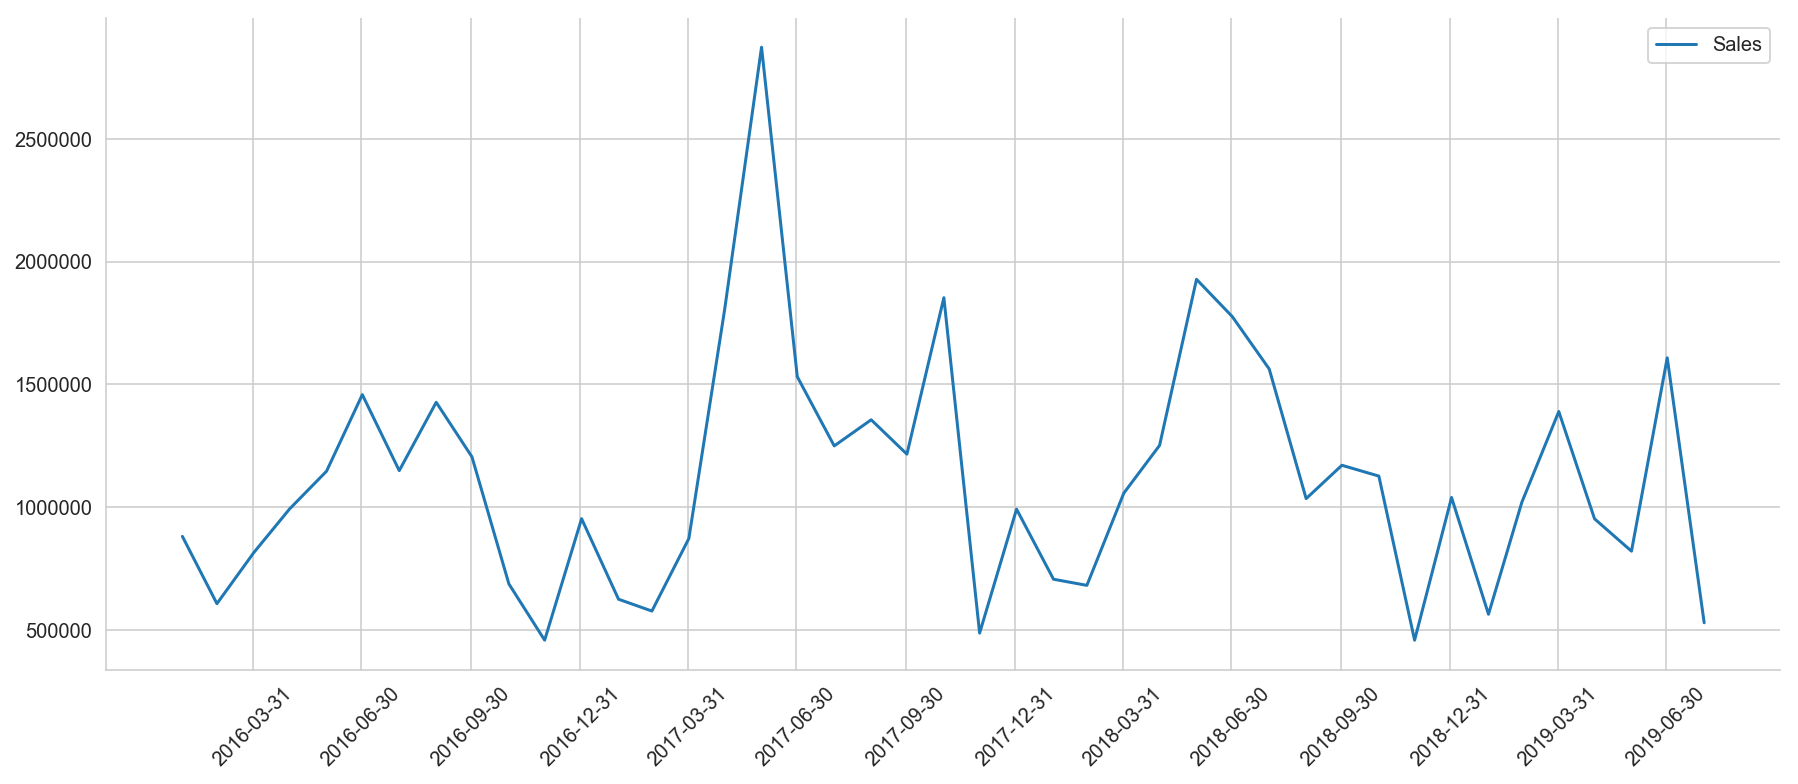

In [19]:
ts = ts.set_index('Flight date')
y = ts['Grossprofit'].resample('MS').sum()
interpolated = y.interpolate(method='spline', order=2)
interpolated.isnull().sum()
interpolated = pd.DataFrame(interpolated)
# y = y.fillna(y.bfill())

#Explore the time series as a data visualization
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))
ax.plot(y.index, interpolated, label='Sales')
plt.legend()
plt.xticks(pd.date_range(interpolated.index[0], interpolated.index[-1], freq='Q'),rotation=45)
# plt.savefig('Sales For CJ.png', dpi=500)
sns.despine()

In [20]:
ts_country = ts.groupby(['brokercountry', 'FlightYearMonth'])['Grossprofit'].sum().reset_index()

KeyError: 'FlightYearMonth'

**Quick observations:**
-  There is an obvious 'seasonality' in summer season and a decreasing 'Trend'.
- Let's check that with a quick decomposition into Trend, seasonality and residuals.

## Visualize the Daily Demand

In [10]:
from pandas import TimeGrouper
from matplotlib import pyplot

In [11]:
Flight_date = ts['Flight date'].sort_values(ascending=True).unique()
Date_list = list(Flight_date)

# Create a list of daily_demand
daily_demand = []
for data in Date_list:
    temp = ts[ts['Flight date'] == data]
    daily_demand.append(len(temp))

C:\Users\BigD\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



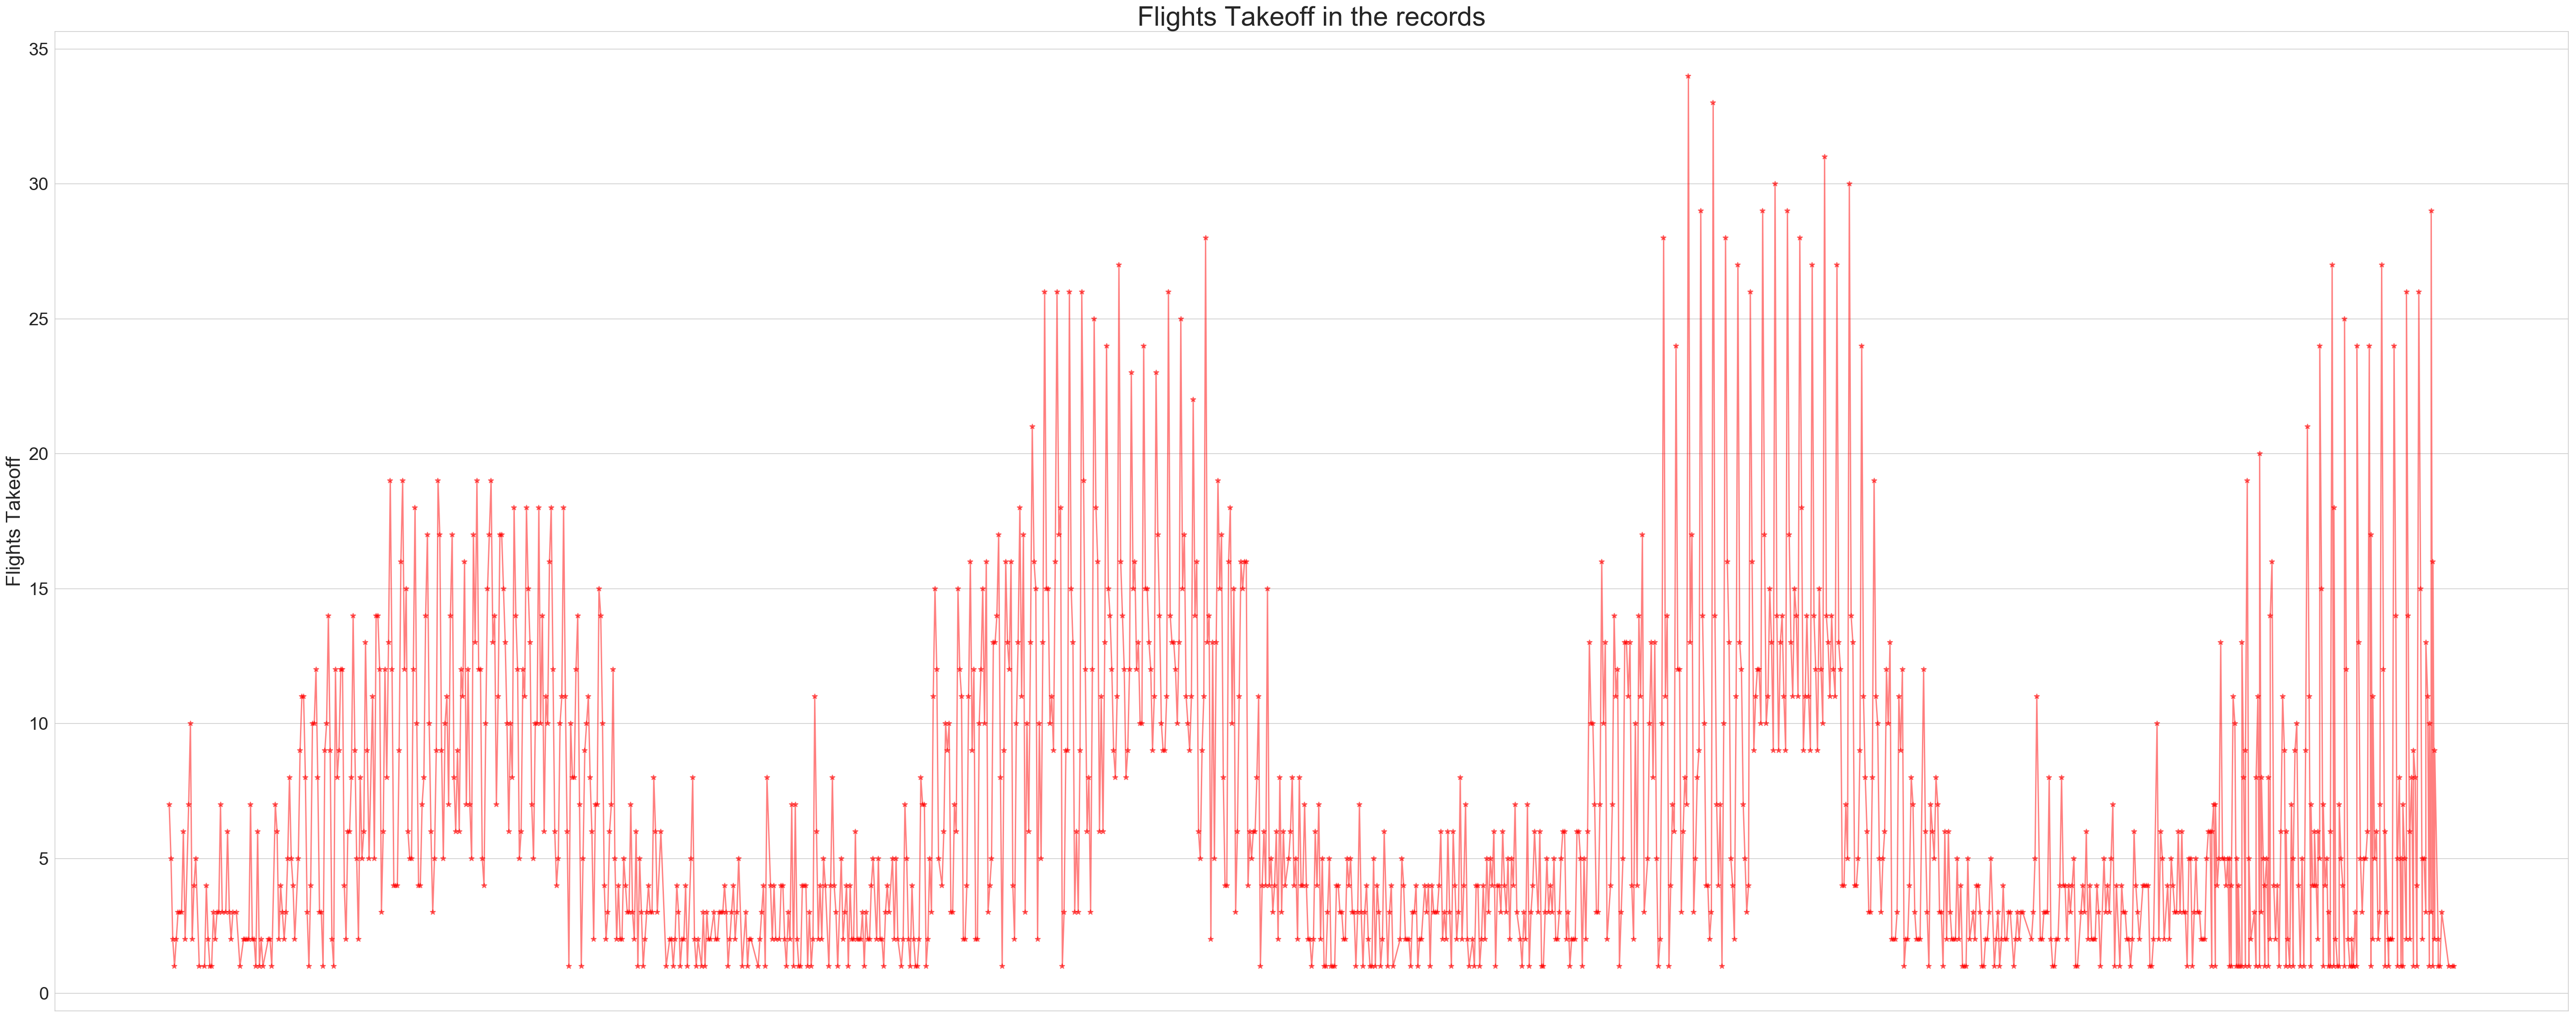

In [12]:
fig = plt.figure(figsize=(50,20))
ax = fig.add_subplot(111)
ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))

plt.plot(Date_list, daily_demand, marker='*', alpha=0.5, c='r')
plt.ylabel('Flights Takeoff',fontsize=22)
plt.yticks(fontsize=20)
plt.xticks(pd.date_range(ts.index[0],ts.index[-1],freq='M'),rotation=45)
plt.title('Flights Takeoff in the records',fontsize=30)
plt.savefig('Monthly Record.png', dpi=500)
plt.show()

## Set the rolling window


In [13]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [21]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

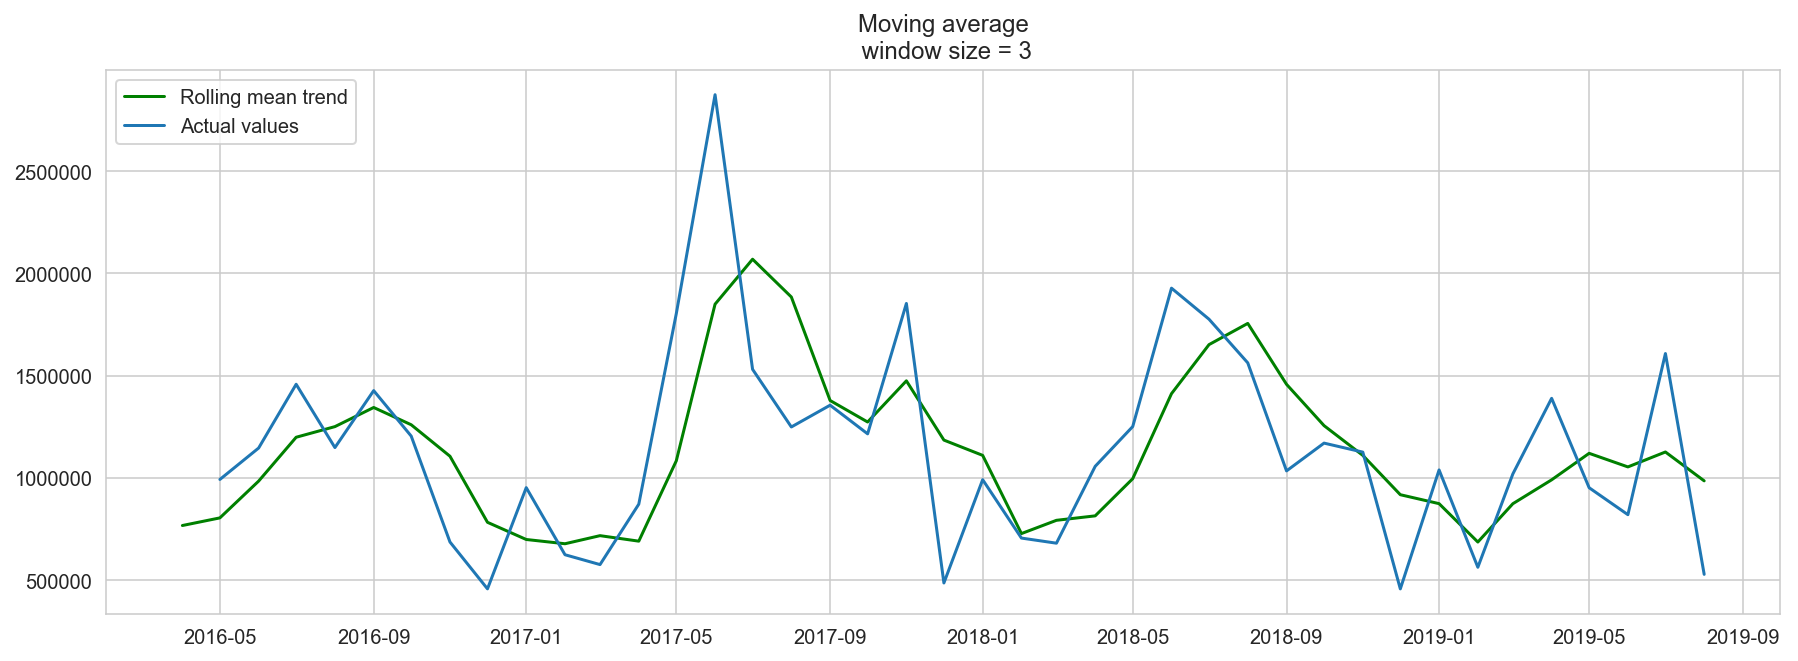

In [22]:
plotMovingAverage(interpolated, 3)

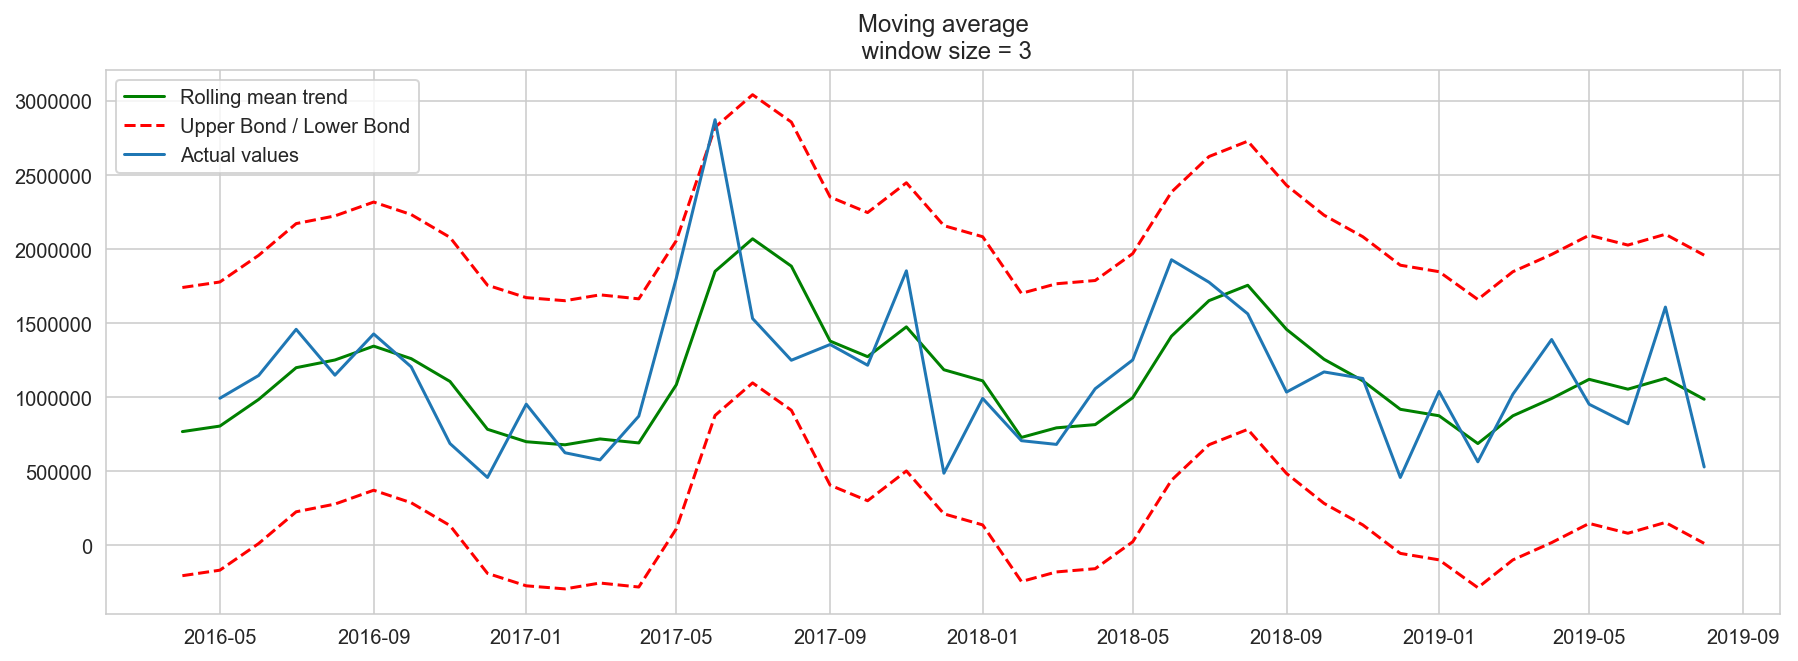

In [23]:
plotMovingAverage(interpolated, 3, plot_intervals=True)

### abnormal value in the dataframe

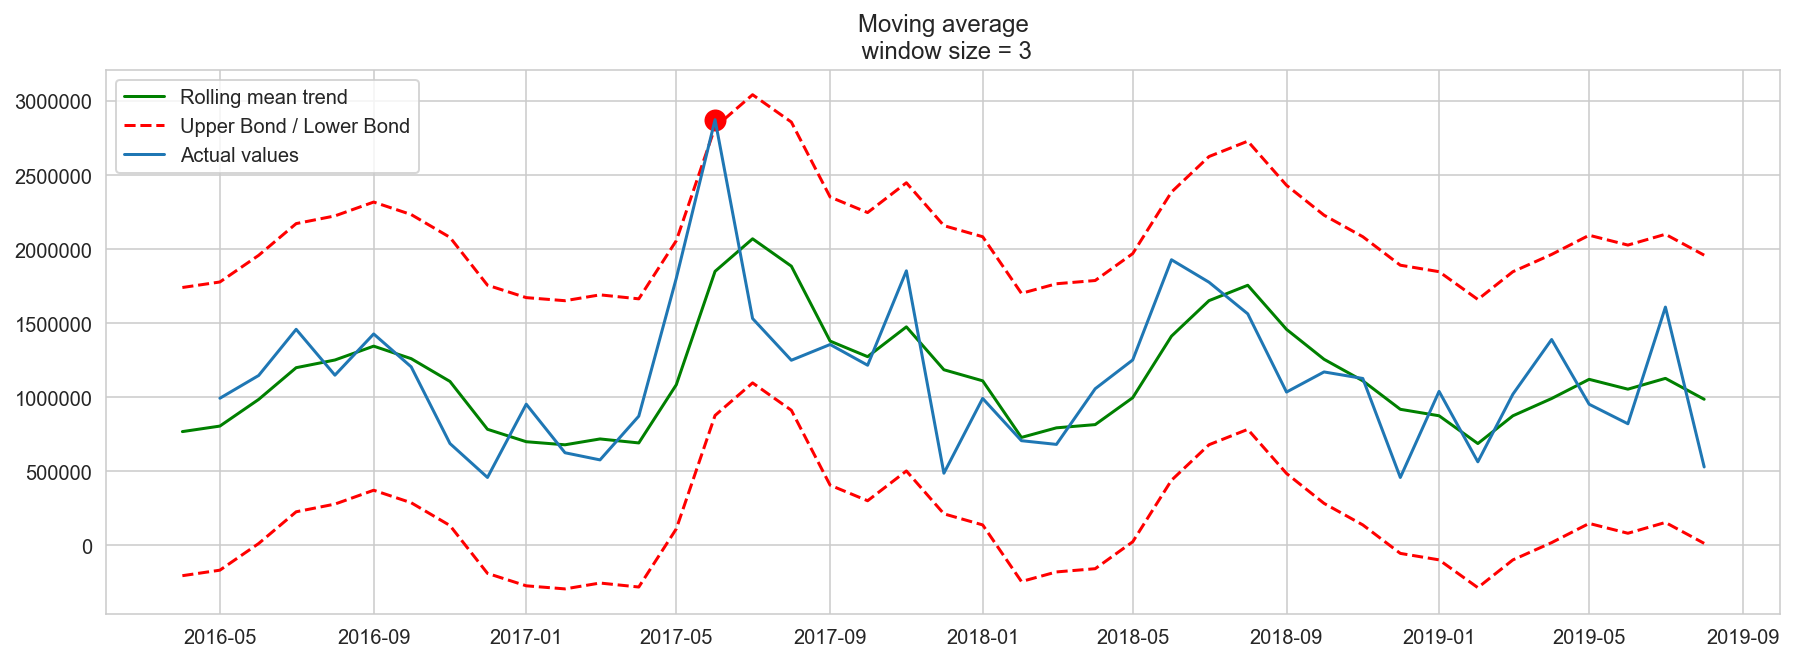

In [24]:
plotMovingAverage(interpolated, 3, plot_intervals=True, plot_anomalies=True)

### Additive model 
- we assume an additive model, then we can write
- yt = St + Tt + Et
- where yt is the data at period t, St is the seasonal component at period t, Tt is the trend-cycle component at period tt and Et is the remainder (or irregular or error)

In [25]:
from pylab import rcParams
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

C:\Users\BigD\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



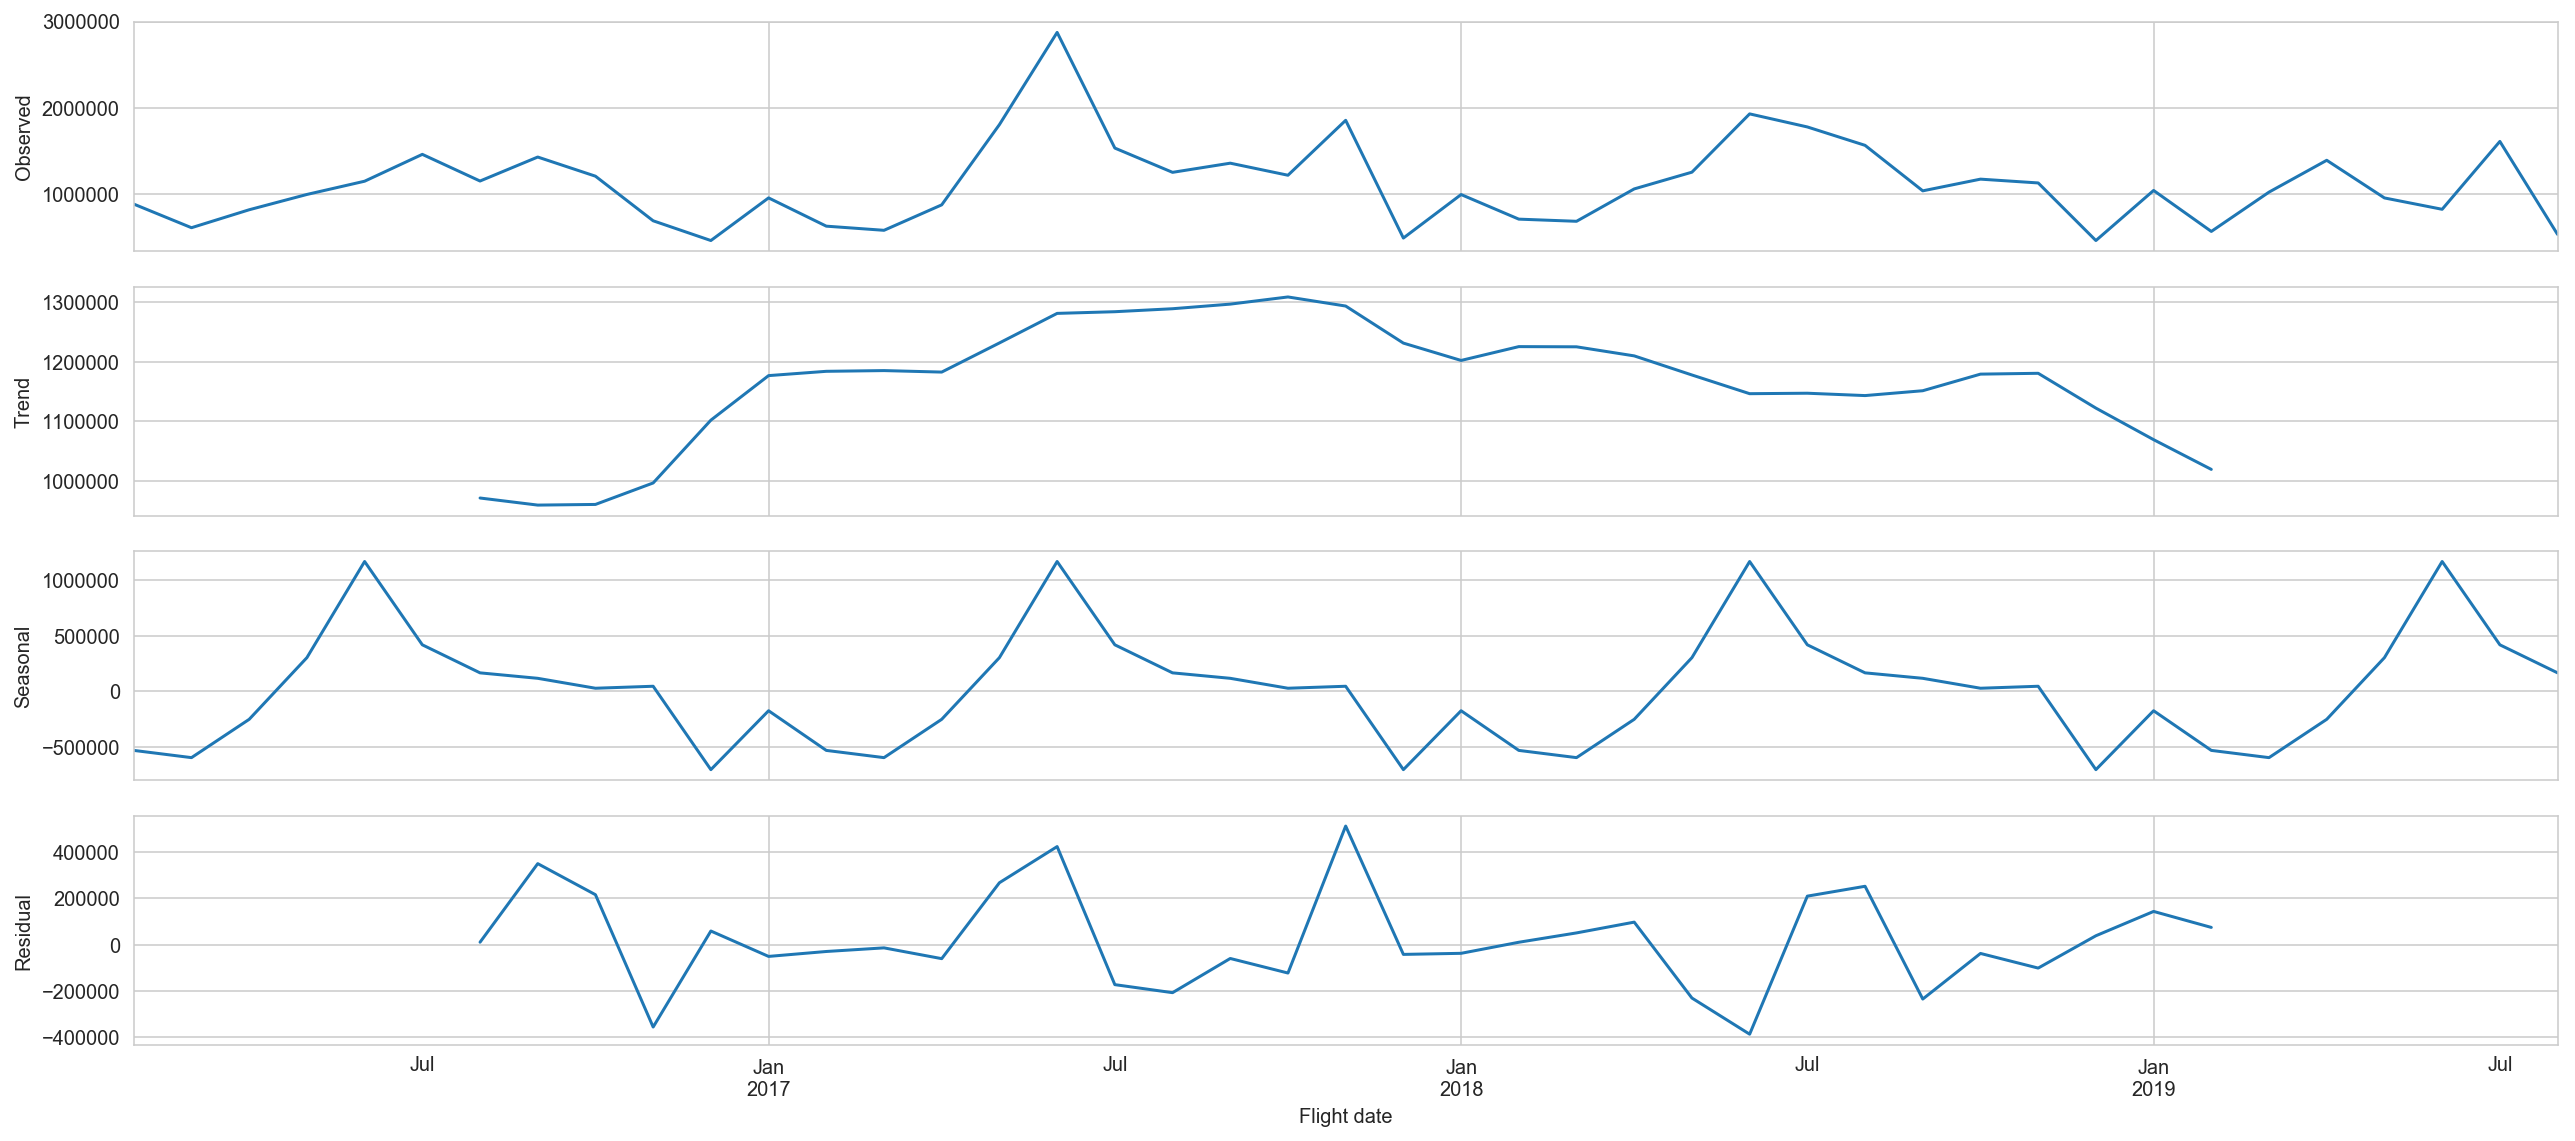

In [26]:
rcParams['figure.figsize'] = 18, 8

residual = sm.tsa.seasonal_decompose(interpolated, freq = None, model = 'additive')
fig = residual.plot()
fig.show()

### Stationarity Tests
- stationarity refers to time-invariance of a series.
- When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary.
    - ADF( Augmented Dicky Fuller Test)

In [27]:
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic

In [28]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    test = adfuller(timeseries, autolag = 'AIC')
    output = pd.Series(test[:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation Used'])
    
    for key, value in test[4].items():
        output['Critical Value (%s)' % key] = value
    print(output)

test_stationarity(y)    

Results of Dickey-Fuller Test:
Test Statistic                -4.177436
p-value                        0.000719
#Lags Used                     0.000000
Number of Observation Used    42.000000
Critical Value (1%)           -3.596636
Critical Value (5%)           -2.933297
Critical Value (10%)          -2.604991
dtype: float64


### Trend Removal
- difference method

In [29]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

def inverse_difference(last_observation, value):
    return value + last_observation

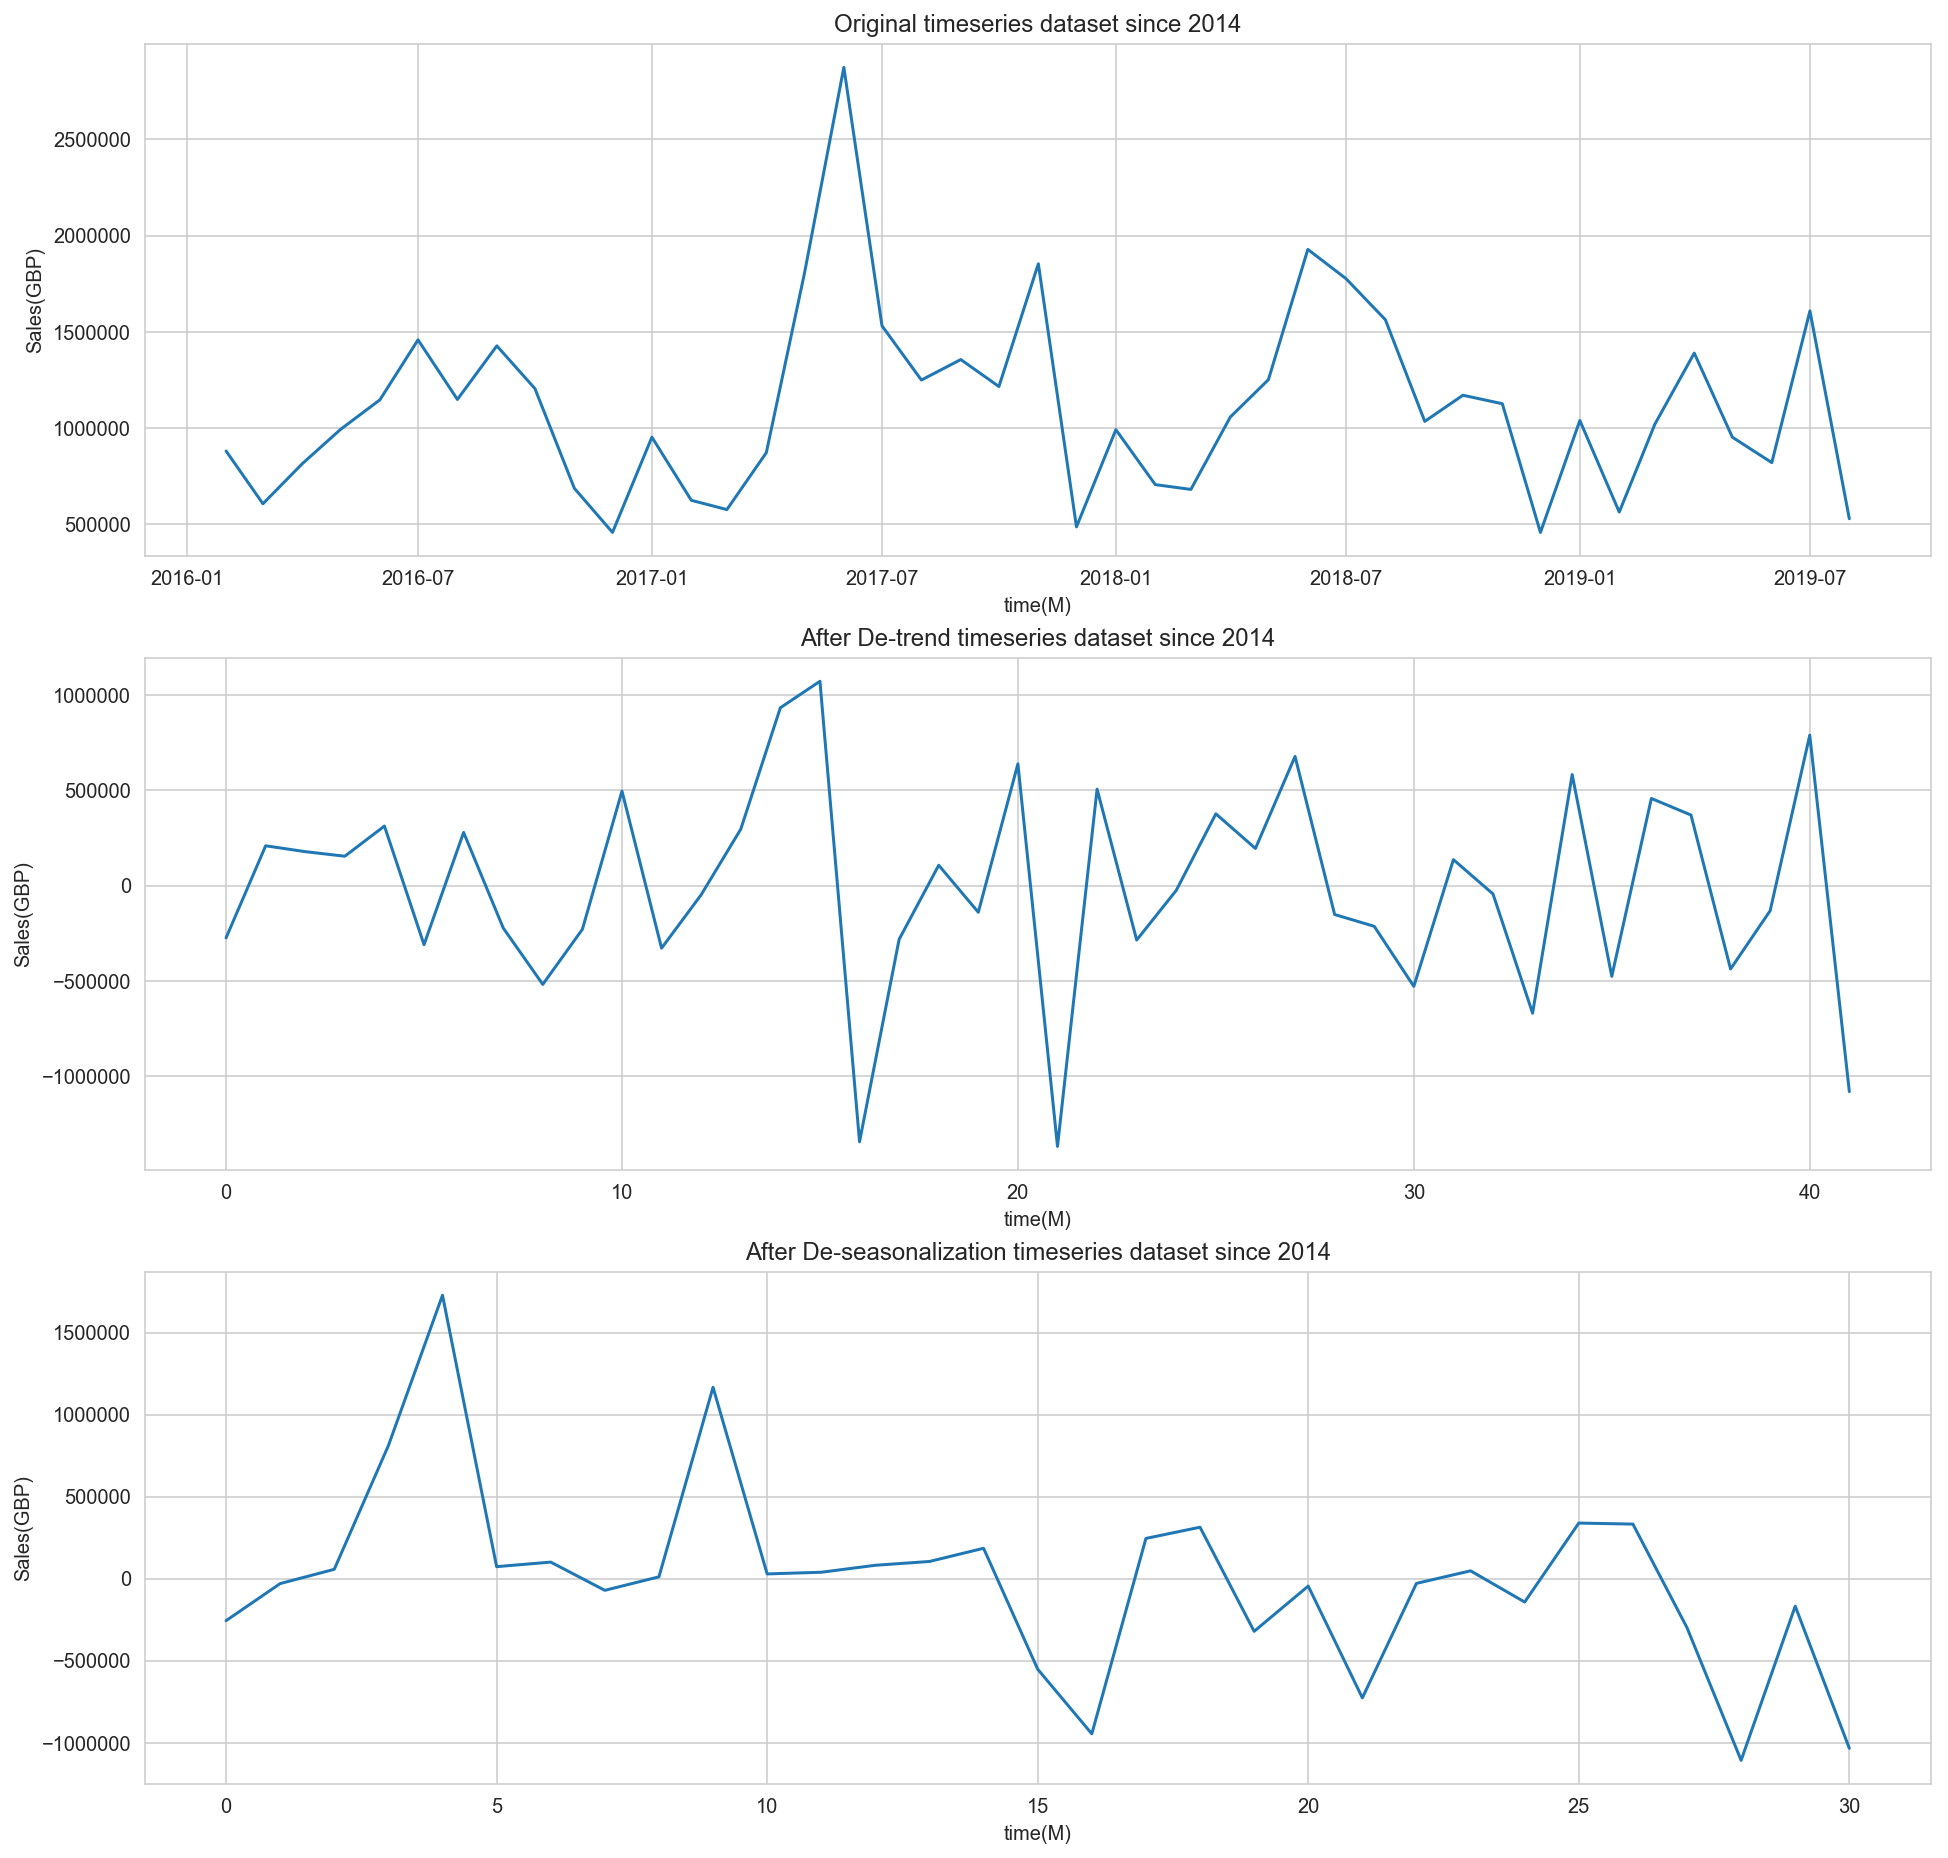

In [30]:
fig = plt.figure(figsize = (16, 16))
plt.subplot(3, 1, 1)
plt.plot(y)

plt.xlabel('time(M)')
plt.ylabel('Sales(GBP)')
plt.title('Original timeseries dataset since 2014')

plt.subplot(3, 1, 2)
plt.plot(difference(y))

plt.xlabel('time(M)')
plt.ylabel('Sales(GBP)')
plt.title('After De-trend timeseries dataset since 2014')

plt.subplot(3, 1, 3)
plt.plot(difference(y, interval=12))

plt.xlabel('time(M)')
plt.ylabel('Sales(GBP)')
plt.title('After De-seasonalization timeseries dataset since 2014')
plt.show()

In [31]:
# test the stationarity again after de-seasonality
new_ts = difference(y, 12)
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                -3.689396
p-value                        0.004265
#Lags Used                     0.000000
Number of Observation Used    30.000000
Critical Value (1%)           -3.669920
Critical Value (5%)           -2.964071
Critical Value (10%)          -2.621171
dtype: float64


- Now after the transformations, it is no need to use lags. Hence we can assume Stationarity of the series.

# The ARIMA Time Series Model
- AutoregRessive Integrated Moving Average is a model that can be fitted to time series data in order to better understand or predict future points in the series.
- There are three distinct integers (p, d, q) that are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation ARIMA(p, d, q). Together these three parameters account for seasonality, trend, and noise in datasets:
- p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
- d is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
- q is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

## 平稳性
- 平稳性就是要求经由样本时间序列所得到的拟合曲线，在未来的一段期间内仍能顺着现有的形态"惯性"地延续下去
- 平稳性要求序列的均值和方差不发生明显变化(前提）

### 严平稳与弱平稳
- 严平稳：严平稳表示的分布不随时间的改变而改变
如：白噪声（正太），无论怎么取，都是期望为0，方差为1
- 弱平稳：期望与相关系数（依赖性）不变
未来某时刻的t的值Xt就要依赖于它的过去信息，所以需要依赖性（大部分的数据）

### 差分法：时间序列在t与t-1时刻的差值
- 目的是为了保证数据的稳定性

### Autoregression Model
描述当前值与历史值之间的关系，用变量自身的历史时间数据对自身进行预测

自回归模型的限制
- 自回归模型是用自身的数据进行预测
- 必须具有平稳性
- 必须具有自相关性，随着时间变化而变化的，如果自相关系数小于0.5，则不宜采用
- 自回归只适用于预测与自身前期相关的现象

### Moving-Average Model
- 移动平均模型关注的是自回归模型中的误差项的累加
- 移动平均法能有效地消除预测中的随机波动

### Autocorrelation Function
- 有序的随机变量序列与其自身相比较
自相关函数反映了同一序列在不同时序的取值之间的相关性

## Seasonal ARIMA
- When dealing with seasonal effects, we make use of the seasonal ARIMA, which is denoted as ARIMA(p,d,q) (P,D,Q)s. Here, (p, d, q) are the non-seasonal parameters described above, while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).
- The seasonal ARIMA method can appear daunting because of the multiple tuning parameters involved. In the next section, we will describe how to automate the process of identifying the optimal set of parameters for the seasonal ARIMA time series model.

## Parameter Selection for the ARIMA Time Series Model
- When looking to fit time series data with a seasonal ARIMA model, our first goal is to find the values of ARIMA(p,d,q) (P,D,Q)s that optimize a metric of interest.
- We will use a "grid search" to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality. Once we have explored the entire landscape of parameters, our optimal set of parameters will be the one that yields the best performance for our criteria of interest.

In [32]:
# Define the p, d, and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


- When evaluating and comparing statistical models fitted with different parameters, each can be ranked against one another based on how well it fits the data or its ability to accurately predict future data points. 
- We will use the AIC(Akaike Information Criterion) value, which measures how well a model fits the data whill taking into account the overall complexity of the model.
- A model that fits the data very well while using lots of feautres will be assigned a larger AIC score than a model that uses fewerer features to achieve the same goodness-of-fit. (We are interested in finding the model that yields the lowest AIC value.)
- The order argument specifies the (p, d, q) parameters, while the seasonal_order argument specifies the (P, D, Q, S) seasonal component of the Seasonal ARIMA model.

In [64]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(interpolated,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

C:\Users\BigD\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1328.713573899563
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:4123.099672421639
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:912.6842670979014
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1277.9004648458676
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1277.5153199198935
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:914.6620437457966
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1306.3352989898456
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:4202.118699686228
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:911.044188744263
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1302.636820359209
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1304.622991173871
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:913.0310926296837
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1229.603685887918
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:4030.2848078606376
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:894.0594355990244
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:1230.0047263618899
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1234.4907435392647
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:892.793658794851
ARIMA(

- The output of our code suggests that the SARIMAX(1, 1, 1) * (1, 1, 1, 12) yields the lowest AIC value of 277.78. We should therefore consider this to be option out of all the models we have considered.

## Fitting an ARIMA Time Series Model
- Using grid search, we have identified the set of parameteres that produces the best fitting models to our time series data. We can proceed to analyze the particular model in mode depth.

In [65]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0331      0.470      0.071      0.944      -0.887       0.954
ma.L1         -0.6908      0.448     -1.543      0.123      -1.568       0.187
ar.S.L12      -0.3053      0.261     -1.172      0.241      -0.816       0.205
sigma2      3.131e+11   3.86e-13   8.11e+23      0.000    3.13e+11    3.13e+11


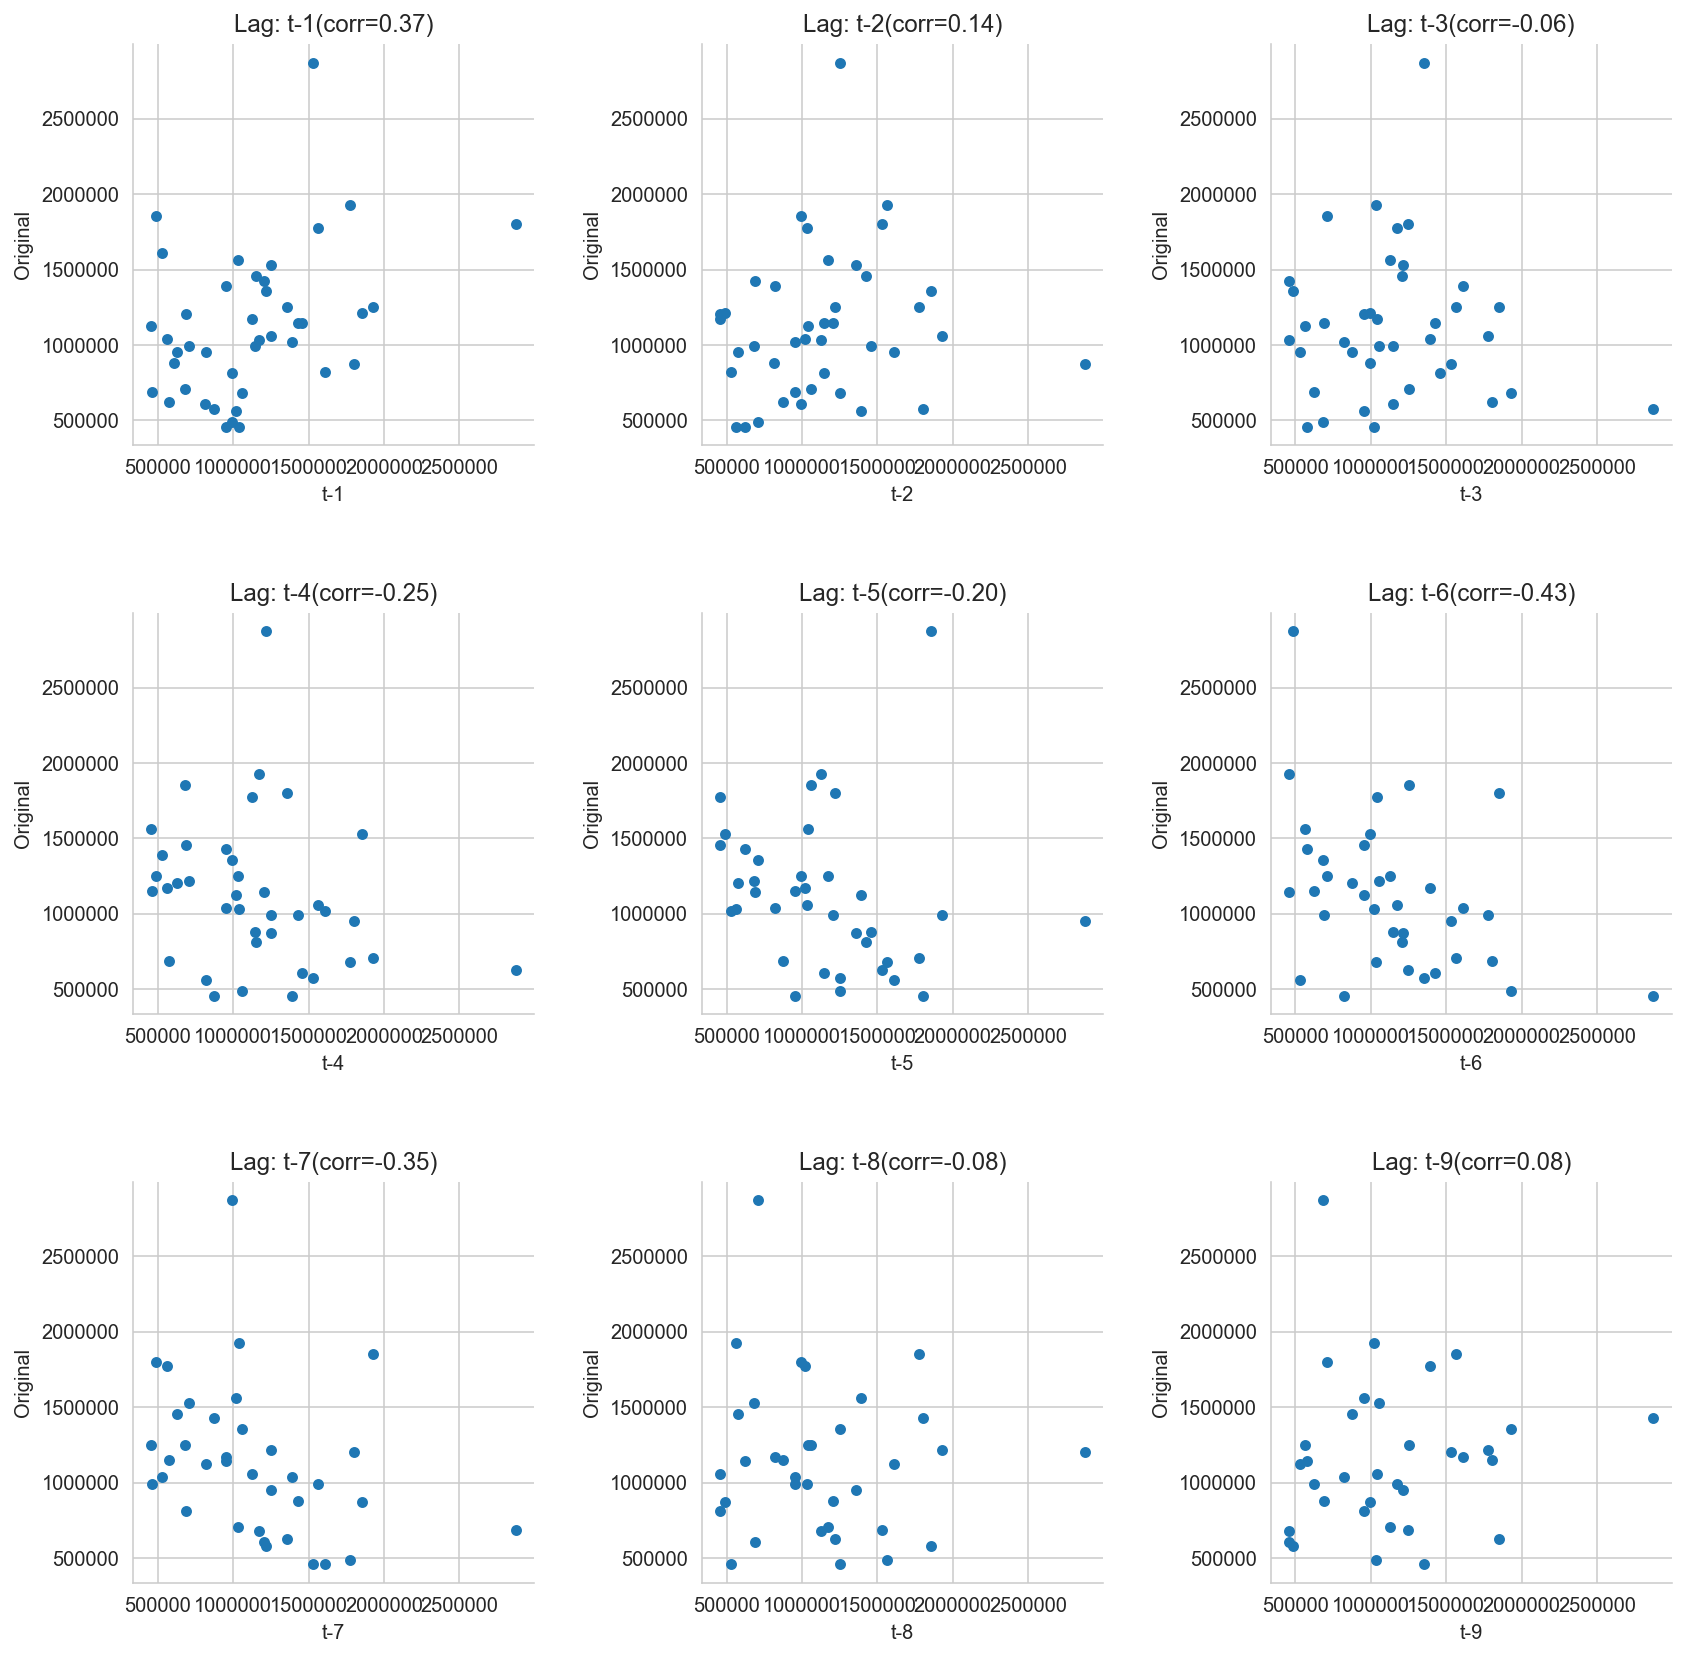

In [66]:
lags = 9

ncols = 3
nrows = int(np.ceil(lags/ncols))

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))
for ax, lag in zip(axes.flat, np.arange(1, lags+1, 1)):
    lag_str = 't-{}'.format(lag)
    X = pd.concat([y, y.shift(-lag)], axis=1,
                  keys=['y'] + [lag_str]).dropna()
    
    X.plot(ax=ax, kind='scatter', y='y', x=lag_str)
    corr = X.corr().values[0][1]
    ax.set_ylabel('Original')
    ax.set_title('Lag: {}(corr={:.2f})'.format(lag_str, corr))
    ax.set_aspect('equal')
    sns.despine()

fig.tight_layout()

In [67]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax = ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    plt.show()
    return ts_ax, acf_ax, pacf_ax

ValueError: operands could not be broadcast together with shapes (35,) (29,) (35,) 

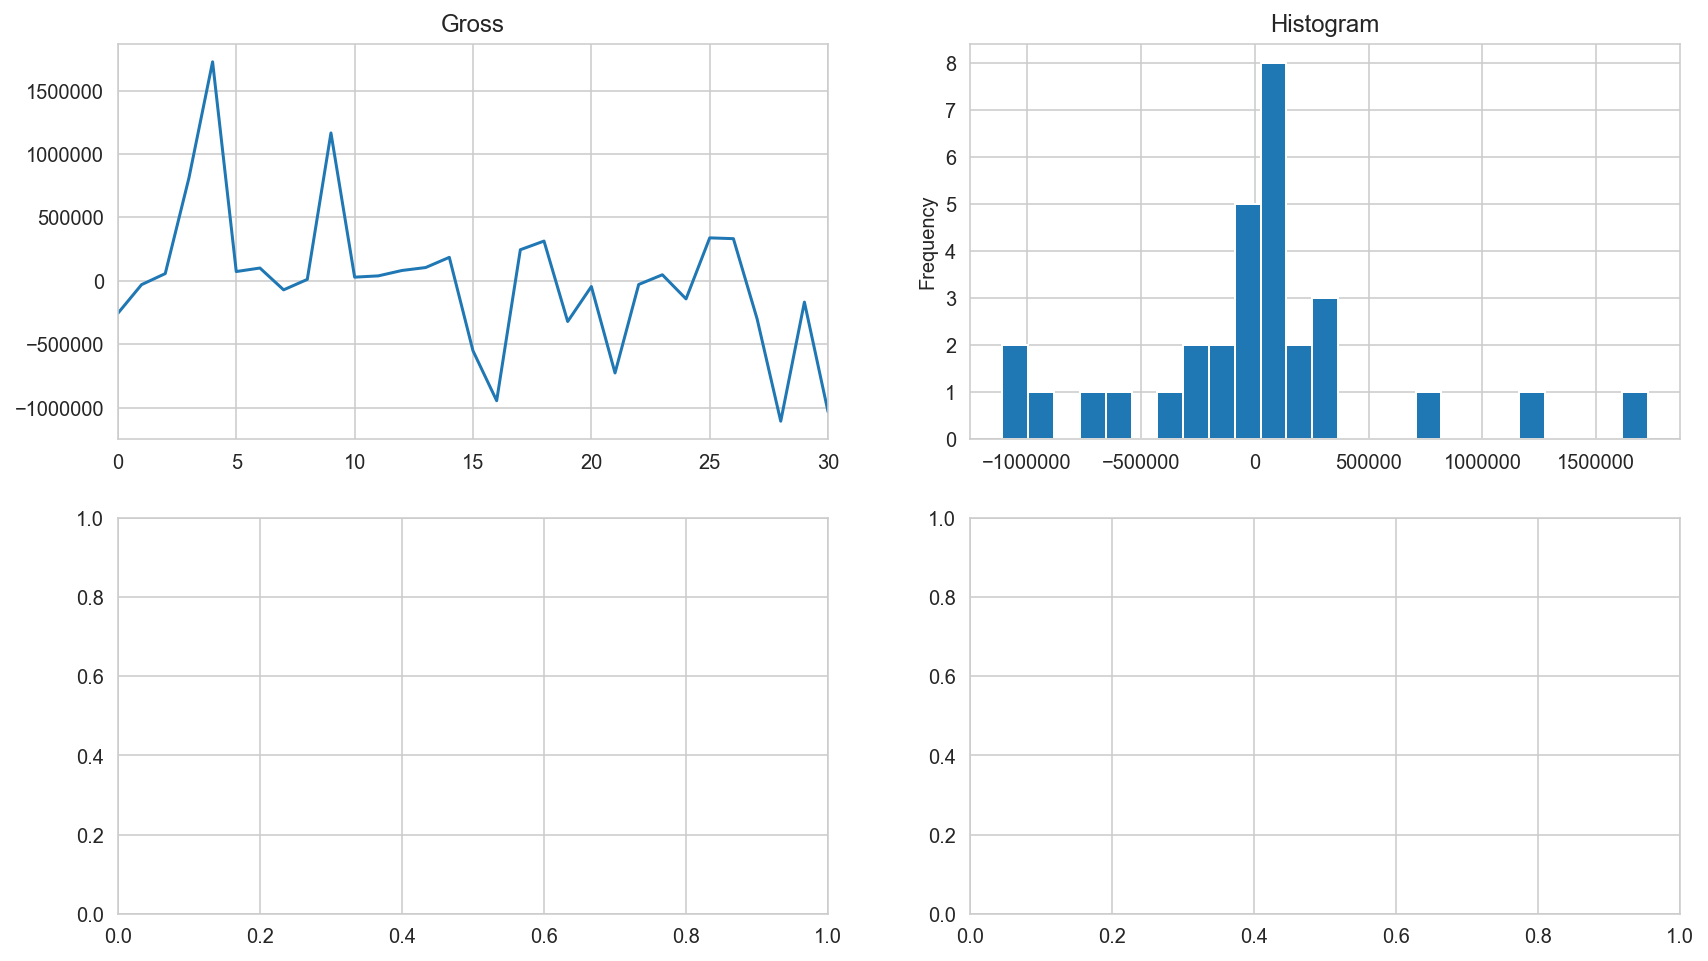

In [63]:
tsplot(new_ts, title='Gross', lags=36)
plt.show()

- The summary attribute that results from the output of SARIMAX returns a significant amount of information, but we'll focus our attention on the table of coefficients. The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

- When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

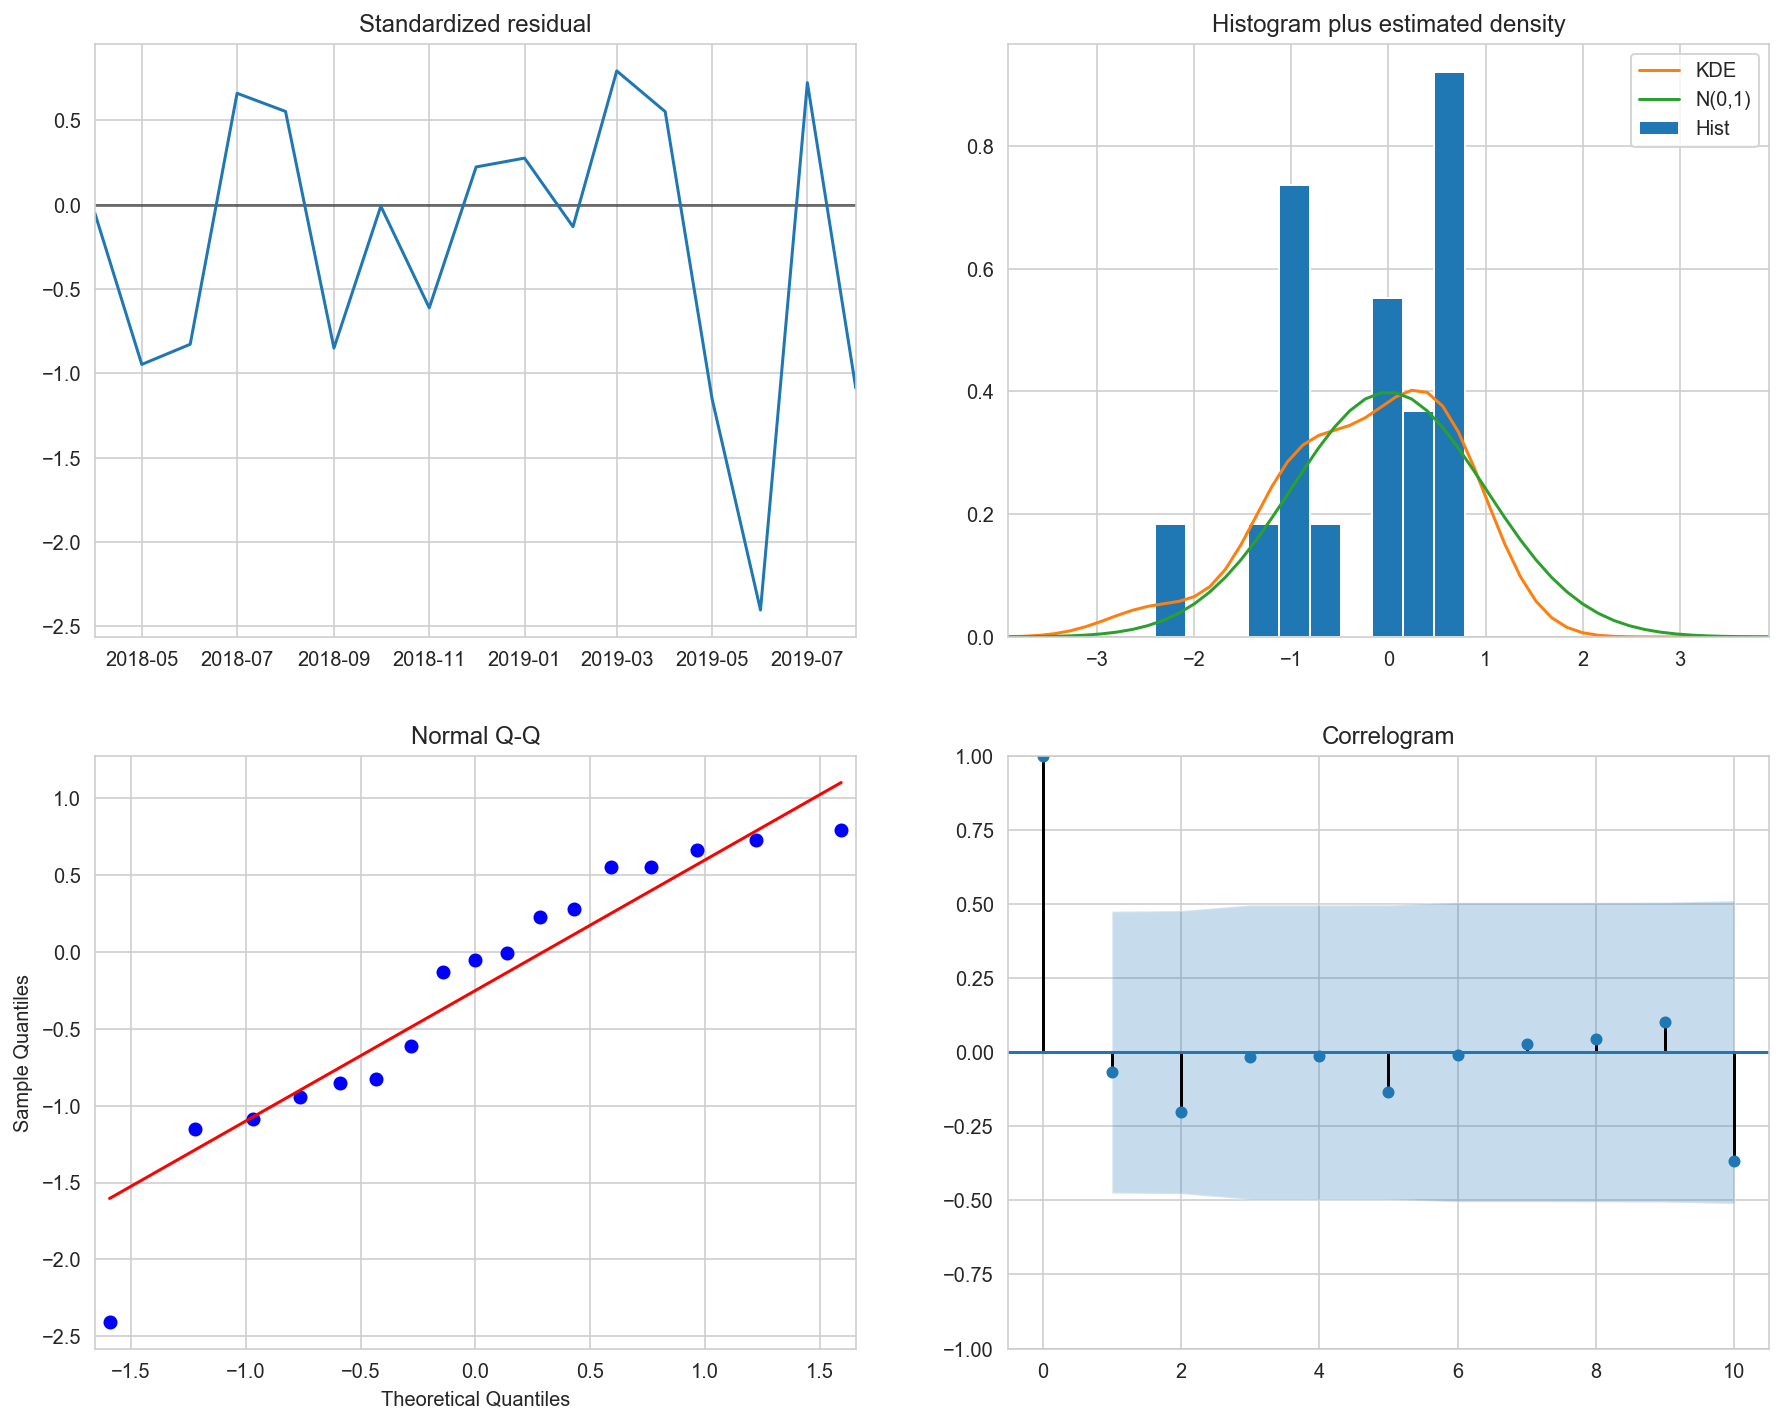

In [68]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

- In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.
- The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.
- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.
Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

Although we have a satisfactory fit, some parameters of our seasonal ARIMA model could be changed to improve our model fit. For example, our grid search only considered a restricted set of parameter combinations, so we may find better models if we widened the grid search.

## Validating Forecasts
- We start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts. 

In [69]:
pred = results.get_prediction(start='2018-01-01', dynamic=False)
# The dynamic=False argument ensures that we produce one-stop ahead forecasts, meaning that forecasts ata each points are generated using the full history up to that point.

pred_ci = pred.conf_int()

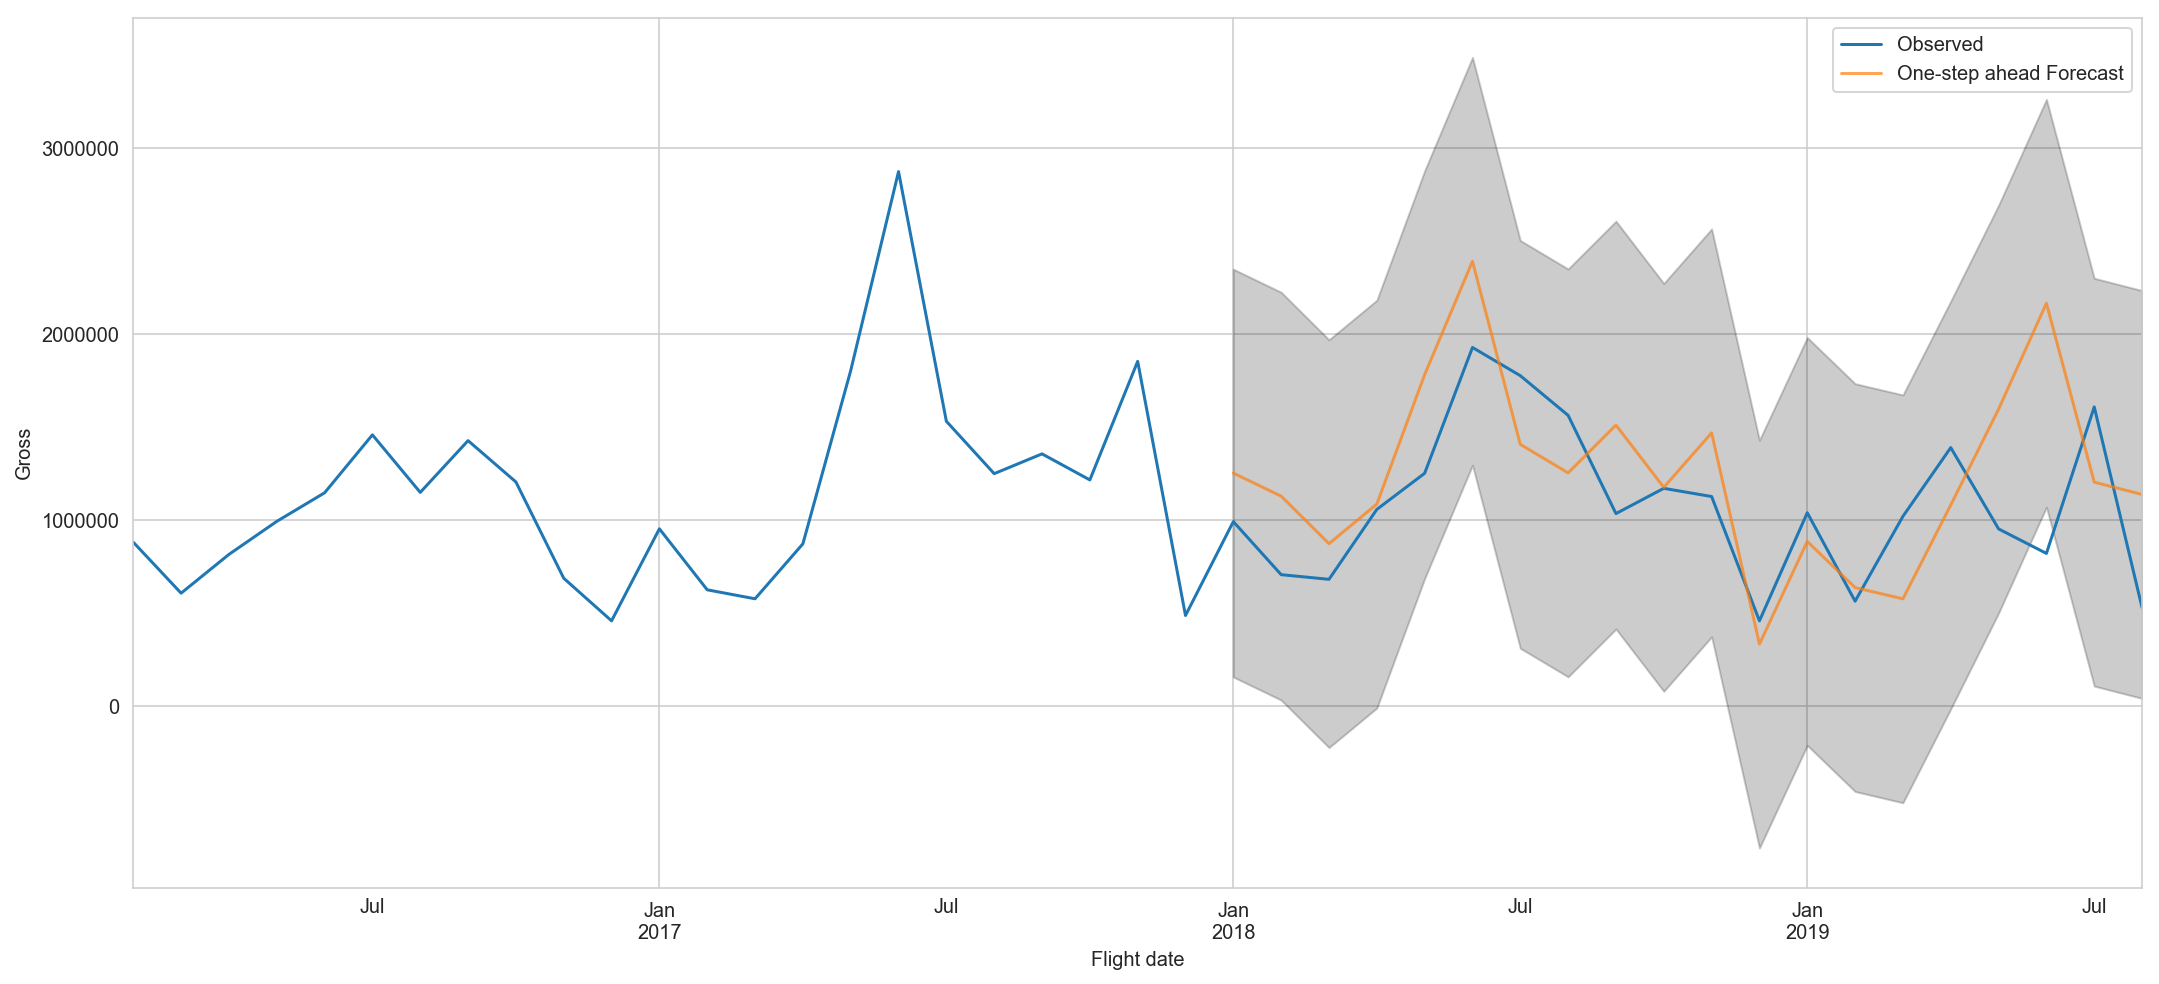

In [70]:
ax = y['2016':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_ylabel('Gross')
plt.legend()
plt.show()

Overall, our forecasts align with the true values very well, showing an overall increase trend.

It is also useful to quantify the accuracy of our forecasts. We will use the MSE (Mean Squared Error), which summarizes the average error of our forecasts. For each predicted value, we compute its distance to the true value and square the result. The results need to be squared so that positive/negative differences do not cancel each other out when we compute the overall mean.

In [71]:
y_forecasted = pred.predicted_mean
y_truth = y['2018-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 222519746410.96
The Root Mean Squared Error of our forecasts is 471719.99


The MSE of our one-step ahead forecasts yields a value of 0.07, which is very low as it is close to 0. An MSE of 0 would that the estimator is predicting observations of the parameter with perfect accuracy, which would be an ideal scenario but it not typically possible.

However, a better representation of our true predictive power can be obtained using dynamic forecasts. In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 151.64 of the real sales. Our furniture daily sales range from around 400 to over 1200. In my opinion, this is a pretty good model so far.


In [72]:
pred_dynamic = results.get_prediction(start='2018-01-01', dynamic=True, full_results=True, typ='levels')
pred_dynamic_ci = pred_dynamic.conf_int()

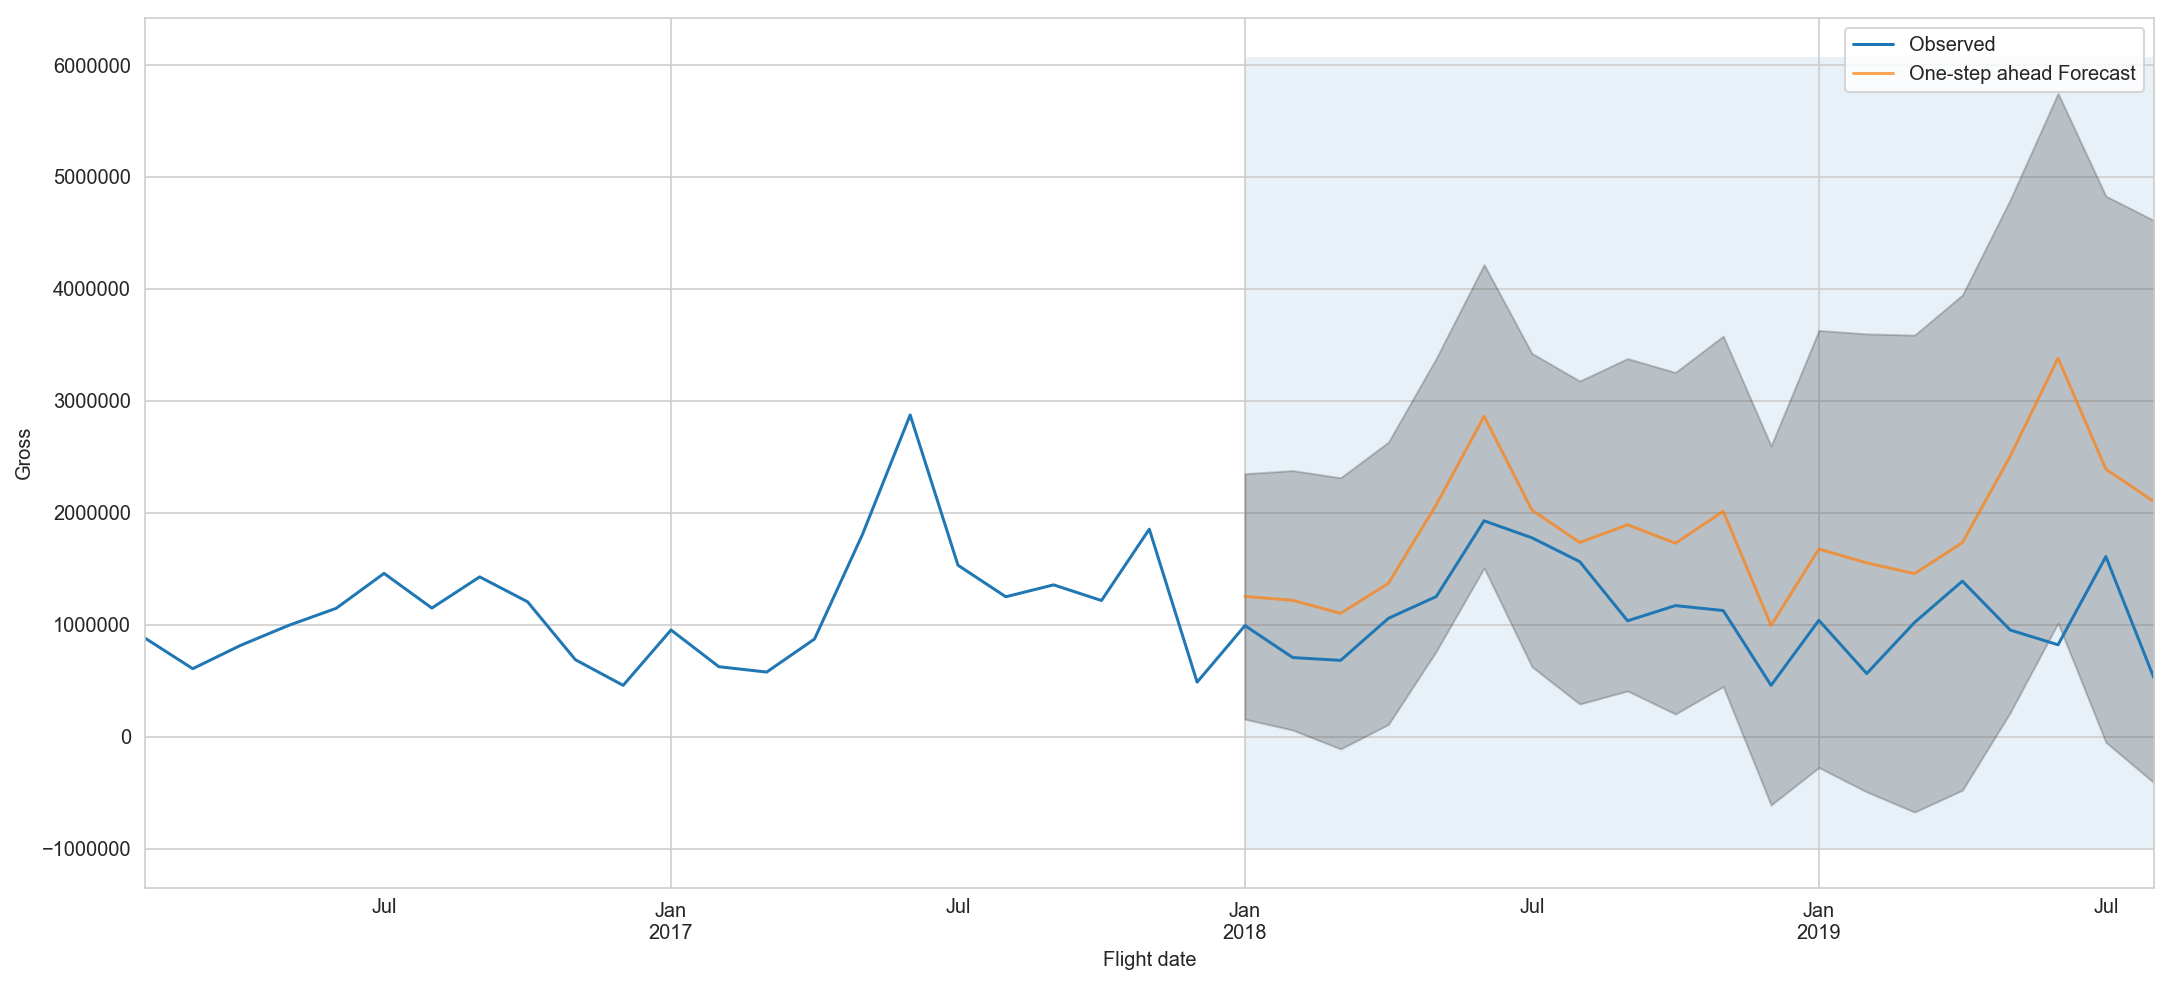

In [73]:
ax = y['2014':].plot(label='Observed')
pred_dynamic.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_ylabel('Gross')
plt.legend()
plt.show()

In [74]:
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['2018-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 904652116778.19
The Root Mean Squared Error of our forecasts is 951132.02


## Producing and Visualizing Forecasts
- In the final step of this tutorial, we describe how to leverage our seasoanl ARIMA time series model to forecast future values.

In [75]:
# Get forecast 30 steps ahead in future
pred_uc = results.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_uc_ci = pred_uc.conf_int()

C:\Users\BigD\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning:

Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.



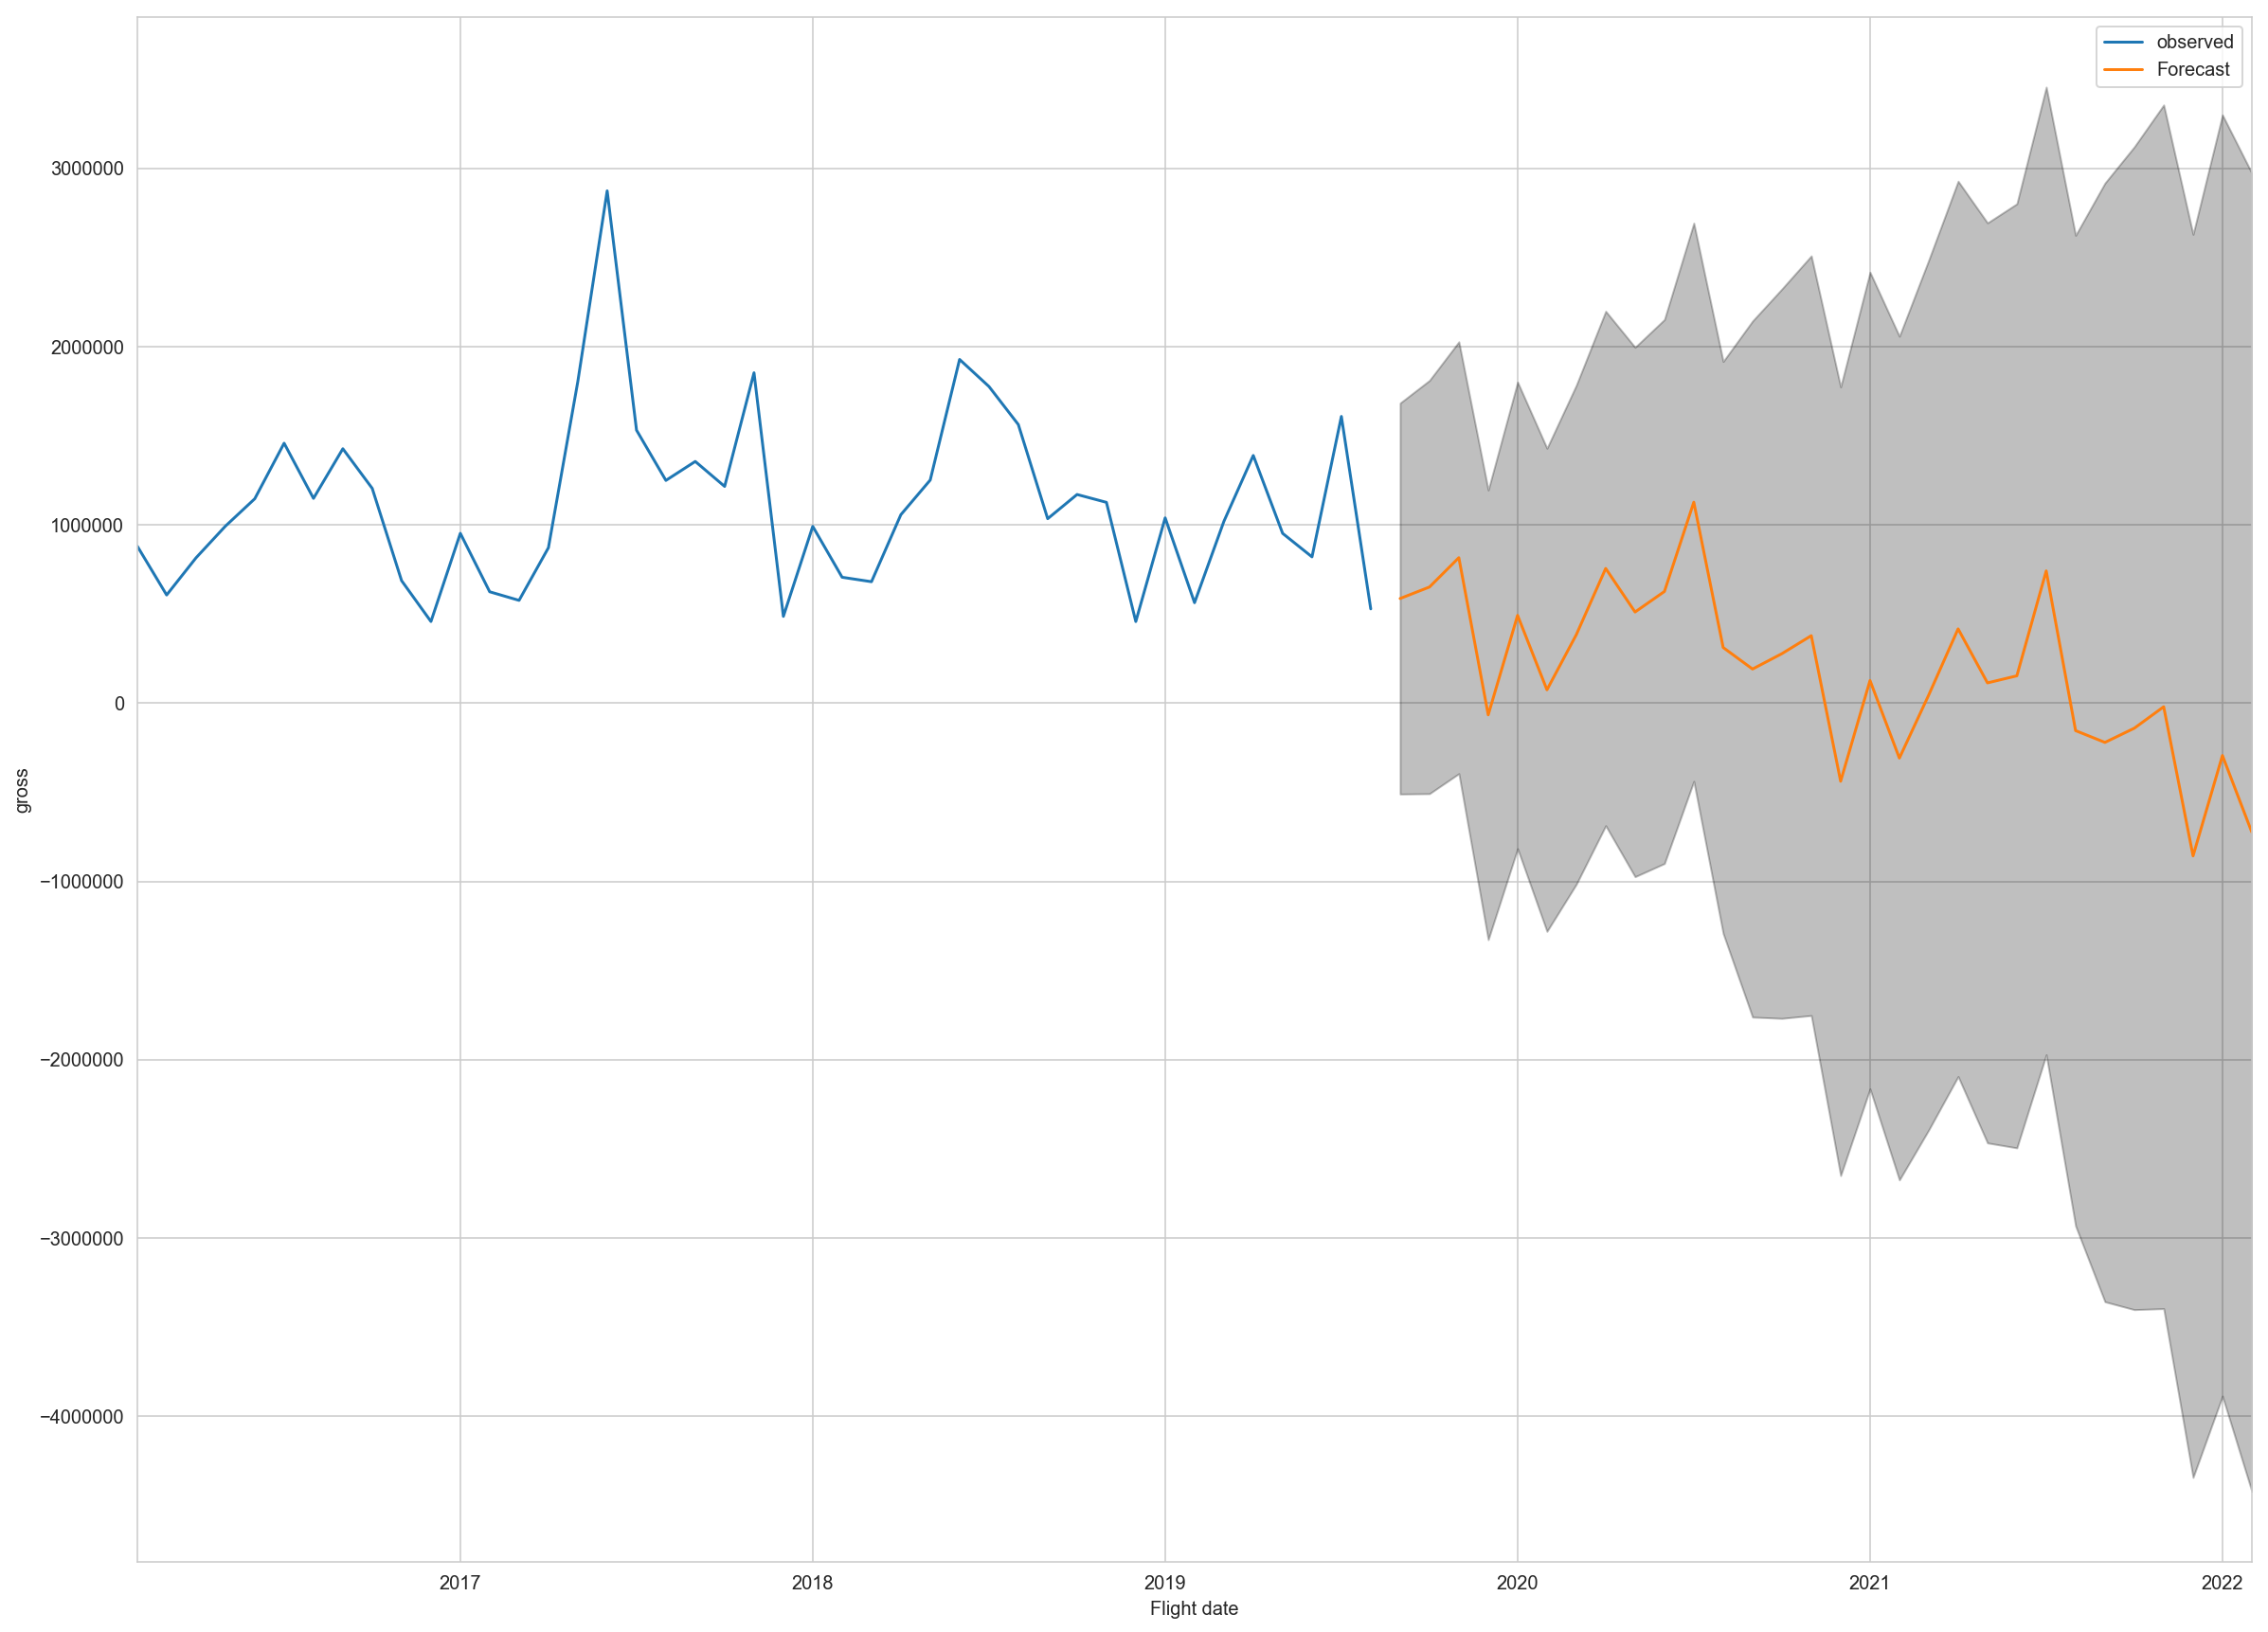

In [76]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_uc_ci.index,
                pred_uc_ci.iloc[:, 0],
                pred_uc_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_ylabel('gross')

plt.legend()
plt.show()

Both the forecasts and associated confidence interval that we have generated can now be used to further understand the time series and foresee what to expect. Our forecasts show that the time series is expected to continue increasing at a steady pace.

As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.